# Imports

In [1]:
# IMPORTS
from distutils.command.config import config
import pickle5 as pickle

# Libraries
import matplotlib.pyplot as plt
import pandas as pd
import wandb
import os
from os.path import exists

# Evaluation
from sklearn.metrics import classification_report, precision_recall_curve, auc, roc_auc_score, \
    accuracy_score, f1_score, recall_score, precision_score, confusion_matrix

import wandb

# Tokenization
from tokenizers import  Tokenizer
from tokenizers.models import BPE
from tokenizers.trainers import BpeTrainer
from tokenizers.pre_tokenizers import Punctuation, Whitespace
from tokenizers.normalizers import Lowercase
from tokenizers import pre_tokenizers, normalizers
from tokenizers.processors import BertProcessing
import glob

# data
import numpy as np
import matplotlib.pyplot as plt

#torch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import Dataset, DataLoader
from collections import Counter
from torch.utils.data import WeightedRandomSampler

# Functions

In [2]:
# Save and Load Functions
def save_checkpoint(save_path, model, optimizer, valid_loss):

    if save_path == None:
        return
    
    state_dict = {'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'valid_loss': valid_loss}
    
    torch.save(state_dict, save_path)
    print(f'Model saved to ==> {save_path}')


def load_checkpoint(load_path, model, optimizer, device):

    if load_path==None:
        return
    
    state_dict = torch.load(load_path, map_location=device)
    print(f'Model loaded from <== {load_path}')
    
    model.load_state_dict(state_dict['model_state_dict'])
    optimizer.load_state_dict(state_dict['optimizer_state_dict'])
    
    return state_dict['valid_loss']


def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

# Load data

In [3]:
CURR_PATH = '/home/svetlanamaslenkova/Documents/AKI_deep/LSTM'
DF_PATH = CURR_PATH +'/dataframes_2/'
TXT_FILES_CODES_PATH = '/home/svetlanamaslenkova/Documents/AKI_deep/LSTM/txt_files/icu_train'
TXT_FILES_NAMES_PATH = '/home/svetlanamaslenkova/Documents/AKI_deep/LSTM/txt_files/icu_train_titles'
TOKENIZER_CODES_PATH = '/home/svetlanamaslenkova/Documents/AKI_deep/LSTM/aki_prediction/tokenizer_icu_codes.json'
TOKENIZER_NAMES_PATH = '/home/svetlanamaslenkova/Documents/AKI_deep/LSTM/aki_prediction/tokenizer_icu_names.json'

PKL_PATH = CURR_PATH+'/pickles_2/'

In [7]:
PKL_PATH

'/home/svetlanamaslenkova/Documents/AKI_deep/LSTM/pickles_2/'

In [124]:
with open(DF_PATH + 'pid_train_dataset_icu.pkl', 'rb') as f:
    pid_train_dataset_icu = pickle.load(f)

with open(DF_PATH + 'pid_test_dataset_icu.pkl', 'rb') as f:
    pid_test_dataset_icu = pickle.load(f)

with open(DF_PATH + 'pid_val_dataset_icu.pkl', 'rb') as f:
    pid_val_dataset_icu = pickle.load(f)

In [138]:
test_data = pid_test_dataset_icu[pid_test_dataset_icu.icu_day_id==1].sort_values(['AKI_1', 'AKI_2', 'AKI_3'], ascending=False).drop_duplicates('stay_id')
print(test_data.AKI_1.sum())
print(test_data.AKI_2.sum())
print(test_data.AKI_3.sum())

135.0
45.0
10.0


In [141]:
train_data = pid_train_dataset_icu[pid_train_dataset_icu.icu_day_id==1].sort_values(['AKI_1', 'AKI_2', 'AKI_3'], ascending=False).drop_duplicates('stay_id')
print(len(train_data))
print(train_data.AKI_1.sum())
print(train_data.AKI_2.sum())
print(train_data.AKI_3.sum())

11409
1044.0
339.0
60.0


In [142]:
val_data = pid_val_dataset_icu[pid_val_dataset_icu.icu_day_id==1].sort_values(['AKI_1', 'AKI_2', 'AKI_3'], ascending=False).drop_duplicates('stay_id')
print(len(val_data))
print(val_data.AKI_1.sum())
print(val_data.AKI_2.sum())
print(val_data.AKI_3.sum())

1425
136.0
40.0
7.0


In [5]:
with open(PKL_PATH + 'aki_stage_labels_second_day.pkl', 'rb') as f:
    aki_stage_labels_second_day = pickle.load(f)
aki_stage_labels_second_day

,subject_id,hadm_id,stay_id,AKI_1,AKI_2,AKI_3,ANY_AKI,NO_AKI
0,18421337,22413411,30000484,0,0,0,0,1
1,12168737,29283664,30001336,0,0,0,0,1
2,34923988,59074770,30001471,0,0,0,0,1
3,13269859,26734917,30002521,0,0,0,0,1
4,15978672,26652960,30002654,1,0,0,1,0
...,...,...,...,...,...,...,...,...
33801,38093900,48704302,39998622,0,1,0,1,0
33802,15669140,29818488,39999172,0,0,0,0,1
33803,13651601,22584645,39999230,0,1,0,1,0
33804,15403458,25335698,39999562,0,0,0,0,1


In [6]:
with open(PKL_PATH + 'aki_stage_labels.pkl', 'rb') as f:
    aki_stage_labels = pickle.load(f)

In [7]:
pid_test_dataset_icu[pid_test_dataset_icu.icu_day_id==1].AKI_1.values.sum()

144.0

In [8]:
pid_train_dataset_icu = pid_train_dataset_icu.replace(r'[{}]', '', regex=True)
pid_test_dataset_icu = pid_test_dataset_icu.replace(r'[{}]', '', regex=True)
pid_val_dataset_icu = pid_val_dataset_icu.replace(r'[{}]', '', regex=True)

In [27]:
pid_val_dataset_icu[pid_val_dataset_icu.demographics.str.len() > 20].drop_duplicates('stay_id').iloc[0].labs_names

'ALT 21.0 ; AST 104.0 ; Absolute Count - Basos 0.01 ; Absolute Count - Eos 0.0 ; Absolute Count - Lymphs 0.24 ; Absolute Count - Monos 0.03 ; Absolute Count - Neuts 0.11 ; Alkaline Phosphate 54.0 ; Anion gap 16.0 ; BUN 49.0 ; Calcium non-ionized 9.3 ; Chloride (serum) 104.0 ; Creatinine (serum) 1.1 ; Differential-Atyps 0.0 ; Differential-Bands 0.0 ; Differential-Basos 2.0 ; Differential-Eos 1.0 ; Differential-Lymphs 61.0 ; Differential-Monos 8.0 ; Differential-Neuts 28.0 ; Direct Bilirubin 0.5 ; Fibrinogen 489.0 ; Glucose (serum) 117.0 ; Glucose finger stick (range 70-100) 163.0 ; HCO3 (serum) 24.0 ; Hematocrit (serum) 19.7 ; Hemoglobin 6.8 ; INR 1.2 ; LDH 1943.0 ; Magnesium 2.1 ; PH (dipstick) 7.5 ; PTT 25.3 ; Phosphorous 3.0 ; Platelet Count 16.0 ; Potassium (serum) 4.5 ; Prothrombin time 13.2 ; Sodium (serum) 140.0 ; Specific Gravity (urine) 1.015 ; Total Bilirubin 4.6 ; Uric Acid 6.3 ; WBC 0.6 '

In [28]:
pid_val_dataset_icu[pid_val_dataset_icu.demographics.str.len() > 20].drop_duplicates('stay_id').iloc[0].labs_codes

'l220228 6.8; l220545 19.7; l220546 0.6; l220587 104.0; l220602 104.0; l220615 1.1; l220621 117.0; l220632 1943.0; l220635 2.1; l220644 21.0; l220645 140.0; l220734 7.5; l225612 54.0; l225624 49.0; l225625 9.3; l225637 0.0; l225638 0.0; l225639 2.0; l225640 1.0; l225641 61.0; l225642 8.0; l225643 28.0; l225651 0.5; l225664 163.0; l225677 3.0; l225690 4.6; l225695 6.3; l227073 16.0; l227442 4.5; l227443 24.0; l227457 16.0; l227465 13.2; l227466 25.3; l227467 1.2; l227468 489.0; l227471 1.015; l229357 0.11; l229358 0.24; l229359 0.03; l229360 0.0; l229361 0.01'

In [285]:
print(pid_train_dataset_icu.drop_duplicates('stay_id').shape[0])
print(np.sum(pid_train_dataset_icu[(pid_train_dataset_icu.icu_day_id==1)].AKI_1.values))
print(np.sum(pid_train_dataset_icu[(pid_train_dataset_icu.icu_day_id==1)].AKI_2.values))
print(np.sum(pid_train_dataset_icu[(pid_train_dataset_icu.icu_day_id==1)].AKI_3.values))

11425
1149.0
366.0
66.0


In [283]:
print(pid_test_dataset_icu.drop_duplicates('stay_id').shape[0])
print(np.sum(pid_test_dataset_icu[(pid_test_dataset_icu.icu_day_id==1)].AKI_1.values))
print(np.sum(pid_test_dataset_icu[(pid_test_dataset_icu.icu_day_id==1)].AKI_2.values))
print(np.sum(pid_test_dataset_icu[(pid_test_dataset_icu.icu_day_id==1)].AKI_3.values))

1428
144.0
48.0
10.0


In [284]:
print(pid_val_dataset_icu.drop_duplicates('stay_id').shape[0])
print(np.sum(pid_val_dataset_icu[(pid_val_dataset_icu.icu_day_id==1)].AKI_1.values))
print(np.sum(pid_val_dataset_icu[(pid_val_dataset_icu.icu_day_id==1)].AKI_2.values))
print(np.sum(pid_val_dataset_icu[(pid_val_dataset_icu.icu_day_id==1)].AKI_3.values))

1429
143.0
42.0
7.0


In [238]:
len(pid_train_dataset_icu.drop_duplicates('stay_id').AKI_1)

11425

In [245]:
pid_train_dataset_icu.head(1)

,subject_id,hadm_id,stay_id,day_id,icu_12h_window_id,icu_day_id,demographics,previous_diags_codes,previous_diags_names,vitals_names,...,labs_codes,outputs_names,outputs_codes,medications_names,medications_codes,AKI_1,AKI_2,AKI_3,icu_12h_info_codes,icu_12h_info_names
33,10002155,28994087,31090461,0.0,0.0,0,WHITE F 82 Blood Pressure 99/51 BMI 21.4 He...,DE9331 D2761 DV4582 D2469 DE8498 D1628 DV4581 ...,Antineoplastic and immunosuppressive drugs cau...,HR 68.0 96.0 bpm; HR Alarm - High 120.0 120....,...,l220224 69.0; l220228 6.0; l220235 37.0; l2205...,Foley 1420.0 ml,o226559 1420.0,,,0.0,0.0,0.0,v220045 68.0 96.0; v220046 120.0 120.0; v220...,HR 68.0 96.0 bpm; HR Alarm - High 120.0 120....


In [254]:
pid_train_dataset_icu.medications_codes

33                                       
34                                m225975
35                        m225911 m225975
36                                m225975
37                        m225911 m225975
                       ...               
476196                    m221794 m221906
476197                    m221794 m221906
476198    m221794 m225909 m225166 m221906
476199                    m221794 m225166
476200                            m221794
Name: medications_codes, Length: 126464, dtype: object

# Train tokenizer

In [6]:
min_frequency = 5

In [9]:
# Training the tokenizer
if exists(TOKENIZER_CODES_PATH):
    tokenizer = Tokenizer.from_file(TOKENIZER_CODES_PATH)
    print(f'Tokenizer is loaded from ==> {TOKENIZER_CODES_PATH}/tokenizer.json. Vocab size is {tokenizer.get_vocab_size()}')
else:
#     print('Training tokenizer...')
#     os.environ["TOKENIZERS_PARALLELISM"] = "true"
#     tokenizer = Tokenizer(BPE(unk_token="UNK"))
#     tokenizer.normalizer = normalizers.Sequence([Lowercase()])
#     # tokenizer.pre_tokenizer = pre_tokenizers.Sequence([Whitespace(), Digits(individual_digits=False), Punctuation( behavior = 'removed')])
#     tokenizer.pre_tokenizer = pre_tokenizers.Sequence([Whitespace(), Punctuation(behavior = 'isolated')])

#     trainer = BpeTrainer(special_tokens=["<s>", "</s>", "PAD", "UNK", "$"], min_frequency=min_frequency)

#     files = glob.glob(TXT_FILES_CODES_PATH+'/*')
#     tokenizer.train(files, trainer)
#     tokenizer.post_processor = BertProcessing(
#             ("</s>", tokenizer.token_to_id("</s>")),
#             ("<s>", tokenizer.token_to_id("<s>")), 
#             )
#     os.environ["TOKENIZERS_PARALLELISM"] = "false"
#     print(f'Vocab size is {tokenizer.get_vocab_size()}')
    print('!')

# tokenizer.save(TOKENIZER_CODES_PATH)

Tokenizer is loaded from ==> /home/svetlanamaslenkova/Documents/AKI_deep/LSTM/aki_prediction/tokenizer_icu_codes.json/tokenizer.json. Vocab size is 8791


# Visualization

In [38]:
# input = pid_train_dataset_icu.iloc[1,:].previous_diags_icd
# input = pid_train_dataset_icu.iloc[1,:].demographics
# input = pid_train_dataset_icu.iloc[1,:].previous_diags_titles
# input = pid_train_dataset_icu.iloc[1,:].vitals
# input = pid_train_dataset_icu.iloc[1,:].vitals_codes
# input = pid_train_dataset_icu.iloc[9,:].labs
input = pid_train_dataset_icu.iloc[9,:].labs_codes
# input = pid_train_dataset_icu.iloc[1,:].outputs
# input = pid_train_dataset_icu.iloc[1,:].medications_names
# input = pid_train_dataset_icu.iloc[1,:].medications_codes
# input = pid_train_dataset_icu.iloc[1,:].icu_12h_info
# input = pid_train_dataset_icu.iloc[1,:].icu_12h_info_titles
input

'l220228 13.0; l220545 39.3; l220546 4.3; l220602 107.0; l220615 0.8; l220621 127.0; l220635 1.6; l220645 142.0; l225624 26.0; l225625 9.4; l225664 126.0; l225677 3.6; l227073 12.0; l227442 4.8; l227443 23.0; l227457 273.0; l227465 11.0; l227466 29.7; l227467 1.0'

In [39]:
output = tokenizer.encode(input)
print(f'number of tokens: {len(output.ids)}')
tokenizer.decode(output.ids)

number of tokens: 96


'l220228 13 . 0 ; l220545 39 . 3 ; l220546 4 . 3 ; l220602 107 . 0 ; l220615 0 . 8 ; l220621 127 . 0 ; l220635 1 . 6 ; l220645 142 . 0 ; l225624 26 . 0 ; l225625 9 . 4 ; l225664 126 . 0 ; l225677 3 . 6 ; l227073 12 . 0 ; l227442 4 . 8 ; l227443 23 . 0 ; l227457 273 . 0 ; l227465 11 . 0 ; l227466 29 . 7 ; l227467 1 . 0'

In [177]:
pid_train_dataset_icu.columns

Index(['subject_id', 'hadm_id', 'stay_id', 'day_id', 'icu_12h_window_id',
       'icu_day_id', 'demographics', 'previous_diags_icd',
       'previous_diags_titles', 'vitals', 'vitals_codes', 'labs', 'labs_codes',
       'outputs', 'outputs_codes', 'medications_names', 'medications_codes',
       'AKI_1', 'AKI_2', 'AKI_3', 'icu_12h_info', 'icu_12h_info_titles'],
      dtype='object')

Retrieve distribution of lengths in tokens 

In [193]:
lengths = {'icu_12h_info':[], 'icu_12h_info_titles':[], 'demographics':[], 'previous_diags_icd':[], \
    'previous_diags_titles':[], 'vitals':[], 'vitals_codes':[], 'labs':[], 'labs_codes':[], 'outputs':[], 'outputs_codes':[], 'medications_names':[], 'medications_codes':[]}

for _, row in pid_train_dataset_icu.iterrows():
    for k,v in lengths.items():
        # print(type(row[k]), row[k], row['hadm_id'])
        length = len(tokenizer.encode(row[k]))
        if length != 0:
            lengths[k].append(length)


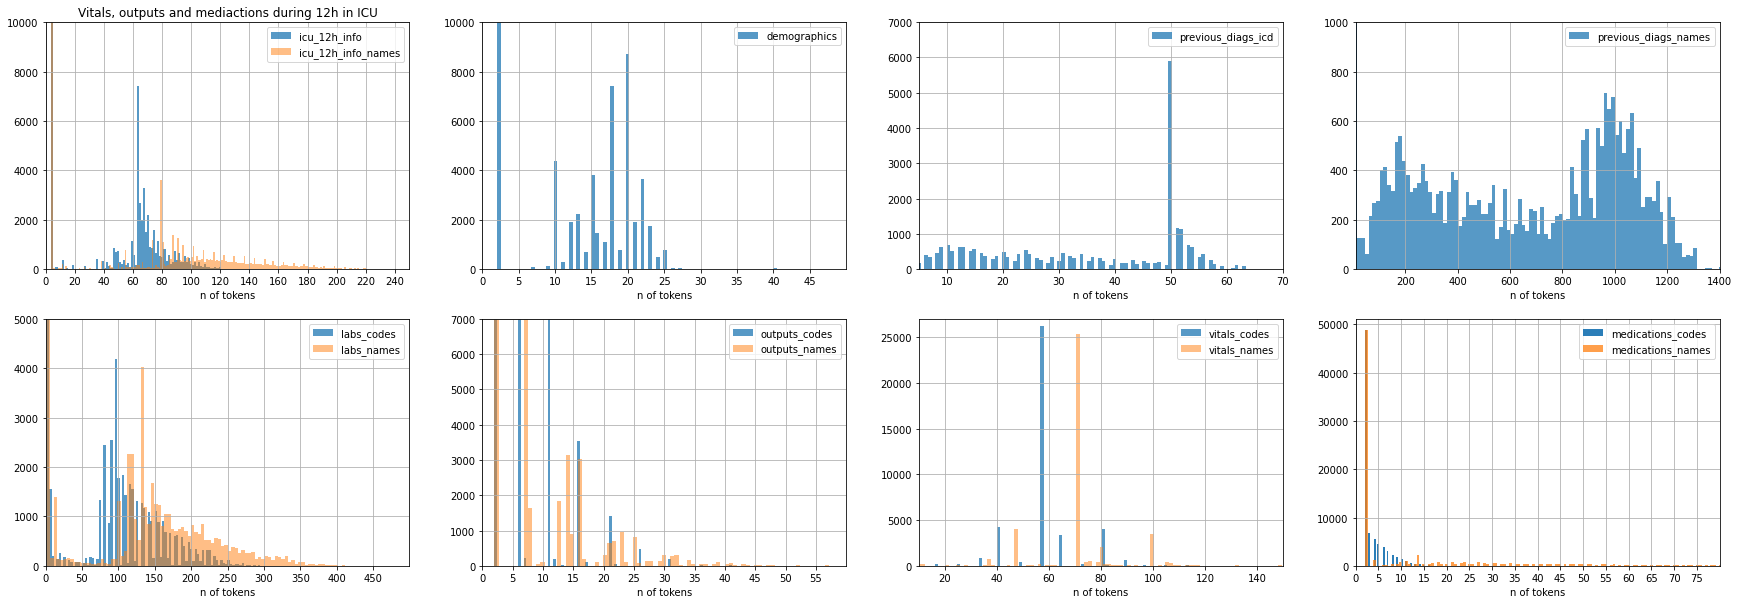

In [195]:
from matplotlib import pyplot as plt

fig, ((ax1,ax2,ax3,ax4),(ax5,ax6,ax7,ax8)) = plt.subplots(2, 4, figsize=(30, 10))

ax1.hist(lengths['icu_12h_info'], bins=100, alpha=0.75, label='icu_12h_info')
ax1.hist(lengths['icu_12h_info_titles'], bins=250, alpha=0.5, label='icu_12h_info_names')
ax1.legend()
ax1.set_xlim([10,250])
ax1.set_ylim([0,10000])
ax1.set_xticks(np.arange(0,250,20))
ax1.set_xlabel('n of tokens')
ax1.set_title('Vitals, outputs and mediactions during 12h in ICU')
ax1.grid(True)

ax2.hist(lengths['demographics'], bins=100, alpha=0.75, label='demographics')
ax2.legend()
ax2.set_xlim([10,50])
ax2.set_ylim([0,10000])
ax2.set_xticks(np.arange(0,50,5))
ax2.set_xlabel('n of tokens')
ax2.grid(True)

ax3.hist(lengths['previous_diags_icd'], bins=100, alpha=0.75, label='previous_diags_icd')
# ax3.hist(lengths['previous_diags_titles'], bins=250, alpha=0.75, label='previous_diags_titles')
ax3.legend()
ax3.set_xlim([5,70])
ax3.set_ylim([0,7000])
ax3.set_xlabel('n of tokens')
ax3.grid(True)

# ax4.hist(lengths['previous_diags_icd'], bins=100, alpha=0.75, label='previous_diags_icd')
ax4.hist(lengths['previous_diags_titles'], bins=100, alpha=0.75, label='previous_diags_names')
ax4.legend()
ax4.set_xlim([10,1400])
ax4.set_ylim([0,1000])
ax4.set_xlabel('n of tokens')
ax4.grid(True)

ax7.hist(lengths['vitals_codes'], bins=100, alpha=0.75, label='vitals_codes')
ax7.hist(lengths['vitals'], bins=100, alpha=0.5, label='vitals_names')
ax7.legend()
ax7.set_xlim([10,150])
ax7.set_ylim([0,27000])
ax7.set_xlabel('n of tokens')
ax7.grid(True)

ax5.hist(lengths['labs_codes'], bins=100, alpha=0.75, label='labs_codes')
ax5.hist(lengths['labs'], bins=100, alpha=0.5, label='labs_names')
ax5.legend()
ax5.set_xlim([10,500])
ax5.set_ylim([0,5000])
ax5.set_xticks(np.arange(0,500,50))
ax5.set_xlabel('n of tokens')
ax5.grid(True)

ax6.hist(lengths['outputs_codes'], bins=100, alpha=0.75, label='outputs_codes')
ax6.hist(lengths['outputs'], bins=100, alpha=0.5, label='outputs_names')
ax6.legend()
ax6.set_xlim([10,60])
ax6.set_ylim([0,7000])
ax6.set_xticks(np.arange(0,60,5))
ax6.set_xlabel('n of tokens')
ax6.grid(True)

ax8.hist(lengths['medications_codes'], bins=50, alpha=0.95, label='medications_codes')
ax8.hist(lengths['medications_names'], bins=300, alpha=0.75, label='medications_names')
ax8.legend()
ax8.set_xlim([10,80])
# ax8.set_ylim([0,2000])
ax8.set_xticks(np.arange(0,80,5))
ax8.set_xlabel('n of tokens')
ax8.grid(True)

plt.show()

In [198]:
print('max outputs_codes', np.max(lengths['outputs_codes']))
print('max medications codes', np.max(lengths['medications_codes']))

max outputs_codes 46
max medications codes 22


In [208]:
max_lengths_dict = {'demographics':30, 'previous_diags_codes':65,'previous_diags_names':1400, 'vitals_names':120, 'vitals_codes':100, 'labs_names':400, \
    'labs_codes':300, 'outputs_names':50, 'outputs_codes':40, 'medications_names':100, 'medications_codes':20,\
         'icu_12h_info_codes':120, 'icu_12h_info_names':220}

In [207]:
final_length = max_lengths_dict['icu_12h_info_codes'] + max_lengths_dict['labs_codes'] + max_lengths_dict['demographics'] + max_lengths_dict['previous_diags_codes']
final_length

515

Since icu_12h_info column already contains info about vitals, outputs and medications, we do not need length of them separately.

# Dataset

In [321]:
max_lengths_dict = {'demographics':30, 'previous_diags_codes':65,'labs_codes':240, 'icu_12h_info_codes':120}

In [38]:
max_lengths_dict = {'demographics':30, 'previous_diags_codes':65,'labs_codes':240, 'icu_12h_info_codes':120}
class MyDataset(Dataset):

    def __init__(self, data_path, tokenizer, labels_df=None, max_length_dict=max_lengths_dict, names=True, pred_window=2, observing_window=2):
        # pred_window: number of 12h windows to predict AKI onset
        # observing_window: number of 12h windows to observe
        self.data_path = data_path
        file_list = glob.glob(self.data_path + '*')
        self.data = []
        for sample in file_list:
            self.data.append(sample)

        self.tokenizer = tokenizer
        self.observing_window = observing_window
        self.pred_window = pred_window
        self.max_length_12h = max_lengths_dict['icu_12h_info_codes']
        self.max_length_24h = max_lengths_dict['labs_codes']
        self.max_length_demo = max_lengths_dict['demographics']
        self.max_length_diags = max_lengths_dict['previous_diags_codes']
        self.labels_df = labels_df[labels_df.icu_day_id==1]
        
    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):

        return self.make_matrices(idx)
    
    def tokenize(self, text, max_length):
        
        try:
            output = self.tokenizer.encode(text)
        except:
            print( type(text), text, max_length, self.stay_id)
            output = self.tokenizer.encode(text[0])

        # padding and truncation
        if len(output.ids) < max_length:
            len_missing_token = max_length - len(output.ids)
            padding_vec = [self.tokenizer.token_to_id('PAD') for _ in range(len_missing_token)]
            token_output = [*output.ids, *padding_vec]
        elif len(output.ids) > max_length:
            token_output = output.ids[:max_length]
        else:
            token_output = output.ids
        
        return token_output

    def preproccess(self, df):
        df['demographics'] = df['demographics'].fillna('')
        df['previous_diags_codes'] = df['previous_diags_codes'].fillna('')
        df['previous_diags_names'] = df['previous_diags_names'].fillna('')
        df['vitals_names'] = df['vitals_names'].fillna('')
        df['vitals_codes'] = df['vitals_codes'].fillna('')
        df['labs_names'] = df['labs_names'].fillna('')
        df['labs_codes'] = df['labs_codes'].fillna('')
        df['outputs_names'] = df['outputs_names'].fillna('')
        df['outputs_codes'] = df['outputs_codes'].fillna('')
        df['medications_names'] = df['medications_names'].fillna('')
        df['medications_codes'] = df['medications_codes'].fillna('')

        df['AKI_1'] = df['AKI_1'].fillna(0)
        df['AKI_2'] = df['AKI_2'].fillna(0)
        df['AKI_3'] = df['AKI_3'].fillna(0)

        df = df[(df.icu_12h_window_id.isin(np.arange(self.min_wind, self.min_wind + self.observing_window +  self.pred_window))) | (df.icu_day_id.isin(np.arange(self.min_day, self.observing_window//2 +  self.pred_window//2)))]
        return df

    def make_matrices(self, idx):
        # load csv file
        sample_path = self.data[idx]
        df = pd.read_csv(sample_path)
        # print('Loaded from ', sample_path)
        
        windows_12h = df.icu_12h_window_id.values
        days = df.icu_day_id.values
        self.min_wind = int( np.max([np.min(windows_12h[~np.isnan(windows_12h)]),0] ) )       
        self.min_day = int( np.max( [np.min(days[~np.isnan(days)]), 0] ))  
        self.df = self.preproccess(df)
        self.stay_id = self.df.stay_id.values[0]  
        # print(stay_id)
        sort = np.argsort(self.df.icu_12h_window_id.values)
        windows_12h = self.df.icu_12h_window_id.values[sort]
        days = self.df.icu_day_id.values[sort]

        info_12h = self.df.icu_12h_info_codes.values[sort]
        info_24h_labs = self.df.labs_codes.values[sort]
        info_demo = self.df.demographics.values[0]
        info_diagnoses = self.df.previous_diags_codes.values[0]

        AKI_1_status = self.df.AKI_1.values[sort]
        AKI_2_status = self.df.AKI_2.values[sort]
        AKI_3_status = self.df.AKI_3.values[sort]

        AKI_1_labels_l = []
        AKI_2_labels_l = []
        AKI_3_labels_l = []
        info_12h_list = []
        info_24h_list = []
        used_day_id_l = []
        used_wind_id_l = []

        wind_12h_pairs = [(i, i+1) for i in range(0, 2*(self.min_day + self.observing_window//2 +  self.pred_window//2), 2)]

        for day in range(self.min_day, self.min_day + self.observing_window//2 +  self.pred_window//2):
            for wind in wind_12h_pairs[day]:
                if wind not in windows_12h:
                    if day not in days:
                    # print('not in days')
                        AKI_1_labels_l.append(0)
                        AKI_2_labels_l.append(0)
                        AKI_3_labels_l.append(0)
                        info_12h_list.append( self.tokenize('',  self.max_length_12h))
                        if day not in used_day_id_l:
                            info_24h_list.append( self.tokenize('',  self.max_length_24h))
                            used_day_id_l.append(day)
                    else:
                        AKI_1_labels_l.append(self.df[self.df.icu_day_id==day].AKI_1.values[0])
                        AKI_2_labels_l.append(self.df[self.df.icu_day_id==day].AKI_2.values[0])
                        AKI_3_labels_l.append(self.df[self.df.icu_day_id==day].AKI_3.values[0])
                        info_12h_list.append(self.tokenize(self.df[self.df.icu_day_id==day].icu_12h_info_codes.values[0],  self.max_length_12h))
                        if day not in used_day_id_l:
                            info_24h_list.append( self.tokenize(self.df[self.df.icu_day_id==day].labs_codes.values[0],  self.max_length_24h))
                            used_day_id_l.append(day)
                else:
                    i = list(windows_12h).index(wind)

                    AKI_1_labels_l.append(AKI_1_status[i])
                    AKI_2_labels_l.append(AKI_2_status[i])
                    AKI_3_labels_l.append(AKI_3_status[i])
                    info_12h_list.append(self.tokenize(info_12h[i], self.max_length_12h))
                    if day not in used_day_id_l:
                        info_24h_list.append(self.tokenize(info_24h_labs[i], self.max_length_24h))
                        used_day_id_l.append(day)
                used_wind_id_l.append(wind)

        demographics = self.tokenize(info_demo, self.max_length_demo)
        diagnoses = self.tokenize(info_diagnoses, self.max_length_diags)

        if self.labels_df is None:
            # making 24h labels from 12h
            AKI_1_labels = [int(bool(np.sum(AKI_1_labels_l[i:i+2]))) for i in np.arange(0, self.observing_window + self.pred_window, 2)]
            AKI_2_labels = [int(bool(np.sum(AKI_2_labels_l[i:i+2]))) for i in np.arange(0, self.observing_window + self.pred_window, 2)]
            AKI_3_labels = [int(bool(np.sum(AKI_3_labels_l[i:i+2]))) for i in np.arange(0, self.observing_window + self.pred_window, 2)]
            
            tensor_labels = torch.tensor([*AKI_1_labels[self.observing_window//2:self.observing_window//2 + self.pred_window//2],\
                                        *AKI_2_labels[self.observing_window//2:self.observing_window//2 + self.pred_window//2],\
                                        *AKI_3_labels[self.observing_window//2:self.observing_window//2 + self.pred_window//2] ]\
                                            , dtype=torch.float64)
        else:
            AKI_1_label = (np.sum(self.labels_df[self.labels_df.stay_id==self.stay_id].AKI_1.values) > 0).astype(int)
            AKI_2_label = (np.sum(self.labels_df[self.labels_df.stay_id==self.stay_id].AKI_2.values) > 0).astype(int)
            AKI_3_label = (np.sum(self.labels_df[self.labels_df.stay_id==self.stay_id].AKI_3.values) > 0).astype(int)
            NO_AKI_label = (np.sum(self.labels_df[self.labels_df.stay_id==self.stay_id].NO_AKI.values) > 0).astype(int)
            tensor_labels = torch.tensor([AKI_1_label, AKI_2_label, AKI_3_label, NO_AKI_label])

        #make tensors
        tensor_12h_info = torch.tensor(info_12h_list[:self.observing_window], dtype=torch.int64)
        tensor_24h_labs = torch.tensor(info_24h_list[:self.observing_window//2], dtype=torch.int64)
        tensor_diagnoses = torch.tensor(diagnoses, dtype=torch.int64)
        tensor_demographics = torch.tensor(demographics, dtype=torch.int64)
    

        return tensor_12h_info, tensor_24h_labs, tensor_diagnoses, tensor_demographics, tensor_labels, {'stay_id':self.stay_id, 'day_id':used_day_id_l, 'wind_id':used_wind_id_l}

## Datset 2

In [104]:
class MyDataset(Dataset):

    def __init__(self, data_path,  tokenizer, labels_df=None, max_length=300, names=True, pred_window=2, observing_window=2):
        # pred_window: number of 12h windows to predict AKI onset
        # observing_window: number of 12h windows to observe
        self.data_path = data_path
        file_list = glob.glob(self.data_path + '*')
        self.data = []
        for sample in file_list:
            self.data.append(sample)

        self.tokenizer = tokenizer
        self.observing_window = observing_window
        self.pred_window = pred_window
        self.max_length = max_length
        if labels_df is not None:
            self.labels_df = labels_df[labels_df.icu_day_id==1]
        else:
            self.labels_df = None

        
    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):

        return self.make_matrices(idx)
    
    def tokenize(self, text, max_length):
        
        try:
            output = self.tokenizer.encode(text)
        except:
            print( type(text), text, max_length, self.stay_id)
            output = self.tokenizer.encode(text[0])

        # padding and truncation
        if len(output.ids) < max_length:
            len_missing_token = max_length - len(output.ids)
            padding_vec = [self.tokenizer.token_to_id('PAD') for _ in range(len_missing_token)]
            token_output = [*output.ids, *padding_vec]
        elif len(output.ids) > max_length:
            token_output = output.ids[:max_length]
        else:
            token_output = output.ids
        
        return token_output

    def preproccess(self, df):
        df['demographics'] = df['demographics'].fillna('')
        df['previous_diags_codes'] = df['previous_diags_codes'].fillna('')
        df['previous_diags_names'] = df['previous_diags_names'].fillna('')
        df['vitals_names'] = df['vitals_names'].fillna('')
        df['vitals_codes'] = df['vitals_codes'].fillna('')
        df['labs_names'] = df['labs_names'].fillna('')
        df['labs_codes'] = df['labs_codes'].fillna('')
        df['outputs_names'] = df['outputs_names'].fillna('')
        df['outputs_codes'] = df['outputs_codes'].fillna('')
        df['medications_names'] = df['medications_names'].fillna('')
        df['medications_codes'] = df['medications_codes'].fillna('')
        df = df.replace(r';', '', regex=True)
        df['AKI_1'] = df['AKI_1'].fillna(0)
        df['AKI_2'] = df['AKI_2'].fillna(0)
        df['AKI_3'] = df['AKI_3'].fillna(0)

        df = df[(df.icu_12h_window_id.isin(np.arange(self.min_wind, self.min_wind + self.observing_window +  self.pred_window))) | (df.icu_day_id.isin(np.arange(self.min_day, self.observing_window//2 +  self.pred_window//2)))]
        return df

    def make_matrices(self, idx):
        # load csv file
        sample_path = self.data[idx]
        df = pd.read_csv(sample_path)
        # print('Loaded from ', sample_path)
        
        windows_12h = df.icu_12h_window_id.values
        days = df.icu_day_id.values
        self.min_wind = int( np.max([np.min(windows_12h[~np.isnan(windows_12h)]),0] ) )       
        self.min_day = int( np.max( [np.min(days[~np.isnan(days)]), 0] ))  
        self.df = self.preproccess(df)
        self.stay_id = self.df.stay_id.values[0]  
        # print(stay_id)
        sort = np.argsort(self.df.icu_12h_window_id.values)
        windows_12h = self.df.icu_12h_window_id.values[sort]
        days = self.df.icu_day_id.values[sort]

        info_12h = self.df.icu_12h_info_codes.values[sort]
        info_24h_labs = self.df.labs_codes.values[sort]
        info_demo = self.df.demographics.values[0]
        info_diagnoses = self.df.previous_diags_codes.values[0]

        AKI_1_status = self.df.AKI_1.values[sort]
        AKI_2_status = self.df.AKI_2.values[sort]
        AKI_3_status = self.df.AKI_3.values[sort]

        AKI_1_labels_l = []
        AKI_2_labels_l = []
        AKI_3_labels_l = []
        info_12h_list = []
        info_24h_list = []
        day_l = []
        info_l = []
        used_day_id_l = []
        used_wind_id_l = []

        wind_12h_pairs = [(i, i+1) for i in range(0, 2*(self.min_day + self.observing_window//2 +  self.pred_window//2), 2)]

        for day in range(self.min_day, self.min_day + self.observing_window//2 +  self.pred_window//2):
            for wind in wind_12h_pairs[day]:
                if wind not in windows_12h:
                    if day not in days:
                    # print('not in days')
                        AKI_1_labels_l.append(0)
                        AKI_2_labels_l.append(0)
                        AKI_3_labels_l.append(0)
                        day_l.append('')
                        if day not in used_day_id_l:
                            day_l.append('')
                            used_day_id_l.append(day)
                    else:
                        AKI_1_labels_l.append(self.df[self.df.icu_day_id==day].AKI_1.values[0])
                        AKI_2_labels_l.append(self.df[self.df.icu_day_id==day].AKI_2.values[0])
                        AKI_3_labels_l.append(self.df[self.df.icu_day_id==day].AKI_3.values[0])
                        day_l.append(self.df[self.df.icu_day_id==day].icu_12h_info_codes.values[0])
                        if day not in used_day_id_l:
                            day_l.append(self.df[self.df.icu_day_id==day].labs_codes.values[0])
                            used_day_id_l.append(day)
                else:
                    i = list(windows_12h).index(wind)

                    AKI_1_labels_l.append(AKI_1_status[i])
                    AKI_2_labels_l.append(AKI_2_status[i])
                    AKI_3_labels_l.append(AKI_3_status[i])
                    day_l.append(info_12h[i])
                    if day not in used_day_id_l:
                        day_l.append(info_24h_labs[i])
                        used_day_id_l.append(day)
                used_wind_id_l.append(wind)
            day_info = ' '.join(day_l)
            info_l.append(self.tokenize(day_info, self.max_length))

        demographics = info_demo
        diagnoses = info_diagnoses
        demo_diags = ' '.join([demographics, diagnoses])
        demo_diags = self.tokenize(demo_diags, 50)

        #make tensors
        tensor_day_info = torch.tensor(info_l[:self.observing_window//2], dtype=torch.int64)
        tensor_demo_diags = torch.tensor(demo_diags, dtype=torch.int64)

        if self.labels_df is None:
            # making 24h labels from 12h
            AKI_1_labels = [int(bool(np.sum(AKI_1_labels_l[i:i+2]))) for i in np.arange(0, self.observing_window + self.pred_window, 2)]
            AKI_2_labels = [int(bool(np.sum(AKI_2_labels_l[i:i+2]))) for i in np.arange(0, self.observing_window + self.pred_window, 2)]
            AKI_3_labels = [int(bool(np.sum(AKI_3_labels_l[i:i+2]))) for i in np.arange(0, self.observing_window + self.pred_window, 2)]
            
            tensor_labels = torch.tensor([*AKI_1_labels[self.observing_window//2:self.observing_window//2 + self.pred_window//2],\
                                        *AKI_2_labels[self.observing_window//2:self.observing_window//2 + self.pred_window//2],\
                                        *AKI_3_labels[self.observing_window//2:self.observing_window//2 + self.pred_window//2] ]\
                                            , dtype=torch.float64)
        else:
            AKI_1_label = (np.sum(self.labels_df[self.labels_df.stay_id==self.stay_id].AKI_1.values) > 0).astype(int)
            AKI_2_label = (np.sum(self.labels_df[self.labels_df.stay_id==self.stay_id].AKI_2.values) > 0).astype(int)
            AKI_3_label = (np.sum(self.labels_df[self.labels_df.stay_id==self.stay_id].AKI_3.values) > 0).astype(int)
            NO_AKI_label = (np.sum([AKI_1_label, AKI_2_label, AKI_3_label]) == 0).astype(int)
            tensor_labels = torch.tensor([AKI_1_label, AKI_2_label, AKI_3_label, NO_AKI_label])

        return tensor_day_info, tensor_demo_diags, tensor_labels, {'stay_id':self.stay_id, 'day_id':used_day_id_l, 'wind_id':used_wind_id_l}

In [297]:
aki_stage_labels_second_day[aki_stage_labels_second_day.stay_id==37143047].AKI_1.values[0]

1

## Checking Dataset class

In [18]:
frac = 1
BATCH_SIZE = 1
test_data_path ='/home/svetlanamaslenkova/Documents/AKI_deep/LSTM/dataframes_2/test_data/'
train_data_path ='/home/svetlanamaslenkova/Documents/AKI_deep/LSTM/dataframes_2/train_data/'
val_data_path ='/home/svetlanamaslenkova/Documents/AKI_deep/LSTM/dataframes_2/val_data/'

test_dataset = MyDataset(data_path=test_data_path, labels_df=aki_stage_labels, tokenizer=tokenizer, max_length_dict=max_lengths_dict)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)

val_dataset = MyDataset(data_path=val_data_path, labels_df=aki_stage_labels, tokenizer=tokenizer, max_length_dict=max_lengths_dict)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True)

train_dataset = MyDataset(data_path=train_data_path, labels_df=aki_stage_labels, tokenizer=tokenizer, max_length_dict=max_lengths_dict)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)


In [149]:
BATCH_SIZE = 8
test_data_path ='/home/svetlanamaslenkova/Documents/AKI_deep/LSTM/dataframes_2/test_data/'
train_data_path ='/home/svetlanamaslenkova/Documents/AKI_deep/LSTM/dataframes_2/train_data/'
val_data_path ='/home/svetlanamaslenkova/Documents/AKI_deep/LSTM/dataframes_2/val_data/'

test_dataset = MyDataset(data_path=test_data_path, labels_df=None, tokenizer=tokenizer, max_length=350)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)

train_dataset = MyDataset(data_path=train_data_path, labels_df=None, tokenizer=tokenizer, max_length=350)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

val_dataset = MyDataset(data_path=val_data_path, labels_df=None, tokenizer=tokenizer, max_length=350)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True)

In [24]:
len(test_dataset)

1428

Try to retrieve all samples from dataset to test for any bugs

In [435]:
i = 0
idx_l = []
cash_l = []
for i in range(0, len(train_dataset)):
    if i%100==0:
        print(f'{i}')
    cash_l.append(cash)
    tensor_12h_info, tensor_24h_labs, tensor_diagnoses, tensor_demographics, tensor_labels, cash = train_dataset[i]

    if i == 0:
        labels_size = tensor_labels.size()

    if tensor_labels.size() != labels_size:
        print(i)
        print(tensor_labels.size())
        print(labels_size)
        print(cash)
        print(tensor_labels)
        break

    i += 1

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400


In [430]:
tensor_12h_info, tensor_24h_labs, tensor_diagnoses, tensor_demographics, tensor_labels, cash = train_dataset[47]
tensor_labels

tensor([0, 1, 0])

In [431]:
aki_stage_labels_second_day[aki_stage_labels_second_day.stay_id==37848539]

,subject_id,hadm_id,stay_id,AKI_1,AKI_2,AKI_3,ANY_AKI,NO_AKI
26651,16958246,21152721,37848539,0,1,0,1,0


In [204]:
i=0
for tensor_day_info, tensor_demo_diags, tensor_labels, cash in train_loader:
    print(f'batch {i}')
    i += 1

batch 0
batch 1
batch 2
batch 3
batch 4
batch 5


In [552]:
tensor_day_info, tensor_demo_diags, tensor_labels, cash = next(iter(test_loader))
# tensor_12h_info, tensor_24h_labs, tensor_diagnoses, tensor_demographics, tensor_labels, cash = next(iter(train_loader))

In [451]:
tensor_12h_info, tensor_24h_labs, tensor_diagnoses, tensor_demographics, tensor_labels, cash = next(iter(test_loader))
tensor_12h_info = tensor_12h_info.cpu().detach().numpy()
tensor_24h_labs = tensor_24h_labs.cpu().detach().numpy()
tensor_diagnoses = tensor_diagnoses.cpu().detach().numpy()
tensor_demographics = tensor_demographics.cpu().detach().numpy()

In [449]:
tensor_12h_info, tensor_24h_labs, tensor_diagnoses, tensor_demographics, tensor_labels, cash  = test_dataset[3]
print(cash)
print(tensor_labels)

{'stay_id': 36800797, 'day_id': [0, 1], 'wind_id': [0, 1, 2, 3]}
tensor([0, 0, 0, 1])


In [486]:
tensor_day_info = tensor_day_info.cpu().detach().numpy()
tensor_demo_diags = tensor_demo_diags.cpu().detach().numpy()

In [509]:
cash

{'stay_id': tensor([38917828, 32678181, 35455848, 31525638, 32602793, 30257222, 31854533,
         39223118]),
 'day_id': [tensor([0, 0, 0, 0, 0, 0, 0, 0]),
  tensor([1, 1, 1, 1, 1, 1, 1, 1])],
 'wind_id': [tensor([0, 0, 0, 0, 0, 0, 0, 0]),
  tensor([1, 1, 1, 1, 1, 1, 1, 1]),
  tensor([2, 2, 2, 2, 2, 2, 2, 2]),
  tensor([3, 3, 3, 3, 3, 3, 3, 3])]}

In [476]:
i = 0

In [553]:
tensor_labels

tensor([[0, 0, 0, 1],
        [0, 0, 0, 1],
        [0, 0, 0, 1],
        [0, 0, 0, 1],
        [0, 1, 0, 0],
        [0, 1, 0, 0],
        [0, 0, 0, 1],
        [0, 0, 0, 1]])

In [218]:
tokenizer.decode(tensor_day_info[i][0])

'v220045 68 . 0 105 . 0 v220046 130 . 0 130 . 0 v220047 50 . 0 50 . 0 v220050 120 . 0 152 . 0 v220051 48 . 0 67 . 0 v220052 69 . 0 136 . 0 v220179 138 . 0 153 . 0 v220180 64 . 0 81 . 0 v220181 82 . 0 97 . 0 v223761 98 . 3 99 . 1 o226560 370 . 0 m221828 m228315 m221833 m222042 m225153 l220228 15 . 1 l220545 44 . 0 l220546 8 . 8 l220587 25 . 0 l220602 105 . 0 l220603 171 . 0 l220615 0 . 9 l220621 137 . 0 l220624 59 . 0 l220632 286 . 0 l220635 2 . 0 l220644 23 . 0 l220645 141 . 0 l225612 60 . 0 l225624 19 . 0 l225625 8 . 8 l225634 74 . 0 l225664 124 . 0 l225671 93 . 0 l225677 2 . 8 l225690 0 . 7 l225693 97 . 0 l227073 16 . 0 l227429 0 . 01 l227442 4 . 2 l227443 23 . 0 l227445 3 . 0 l227456 4 . 2 l227457 142 . 0 l227465 11 . 2 l227466 25 . 2 l227467 1 . 0 v220045 61 . 0 94 . 0 v220046 130 . 0 130 . 0 v220047 50 . 0 50 . 0 v220050 117 . 0 159 . 0 v220051 43 . 0 70 . 0 v220052 66 . 0 98 . 0 v220179 129 . 0 129 . 0 v220180 67 . 0 67 . 0 v220181 81 . 0 81 . 0 v223761 97 . 7 98 . 6 o226560 300 

In [220]:
tokenizer.decode(tensor_demo_diags[i])

'white m 68'

In [569]:
aki_stage_labels[aki_stage_labels.stay_id==30067772]

,subject_id,hadm_id,stay_id,specimen_id,day_id,icu_day_id,icu_12h_window_id,charttime,intime,AKI_1_scr,AKI_2_scr,AKI_3_scr,AKI_1_urine,AKI_2_urine,AKI_3_urine,AKI_1,AKI_2,AKI_3,ANY_AKI,NO_AKI
184535,13073052,28265498,30067772,72964827.0,1,1,2,2169-08-11 04:16:00,2169-08-09 20:15:04,0,0,0,0.0,0.0,0.0,0,0,0,0,1
184536,13073052,28265498,30067772,71115289.0,2,1,3,2169-08-11 13:20:00,2169-08-09 20:15:04,0,0,0,0.0,0.0,0.0,0,0,0,0,1
184537,13073052,28265498,30067772,12723801.0,3,3,6,2169-08-13 02:14:00,2169-08-09 20:15:04,0,0,0,0.0,0.0,0.0,0,0,0,0,1
184538,13073052,28265498,30067772,20496494.0,4,4,8,2169-08-13 21:14:00,2169-08-09 20:15:04,0,0,0,0.0,0.0,0.0,0,0,0,0,1


In [571]:
df = pd.read_csv('/home/svetlanamaslenkova/Documents/AKI_deep/LSTM/dataframes_2/train_data/icu_stay_30067772.csv')
df

,subject_id,hadm_id,stay_id,day_id,icu_12h_window_id,icu_day_id,demographics,previous_diags_codes,previous_diags_names,vitals_names,...,labs_codes,outputs_names,outputs_codes,medications_names,medications_codes,AKI_1,AKI_2,AKI_3,icu_12h_info_codes,icu_12h_info_names
0,13073052,28265498,30067772,NaN,0.0,0,WHITE F 72,,,ABPd 44.0 62.0 mmHg; ABPm 64.0 84.0 mmHg; AB...,...,l220224 112.0; l220227 97.0; l220228 10.0; l22...,Foley 920.0 ml; OR EBL 750.0 ml; OR Urine 350....,o226559 920.0; o226576 110.0; o226626 750.0; o...,Heparin Sodium (Prophylaxis); Fentanyl (Concen...,m225975 m225942 m222168 m221668 m223258 m221749,0.0,0.0,0.0,v220045 81.0 100.0; v220046 120.0 130.0; v22...,ABPd 44.0 62.0 mmHg; ABPm 64.0 84.0 mmHg; AB...
1,13073052,28265498,30067772,NaN,1.0,0,WHITE F 72,,,ABPd 46.0 66.0 mmHg; ABPm 68.0 87.0 mmHg; AB...,...,l220224 112.0; l220227 97.0; l220228 10.0; l22...,Foley 810.0 ml,o226559 810.0,Fentanyl (Concentrate); Potassium Chloride; KC...,m225942 m225166 m227522 m221456,0.0,0.0,0.0,v220045 92.0 123.0; v220046 130.0 130.0; v22...,ABPd 46.0 66.0 mmHg; ABPm 68.0 87.0 mmHg; AB...
2,13073052,28265498,30067772,1.0,2.0,1,WHITE F 72,,,ABPd 50.0 75.0 mmHg; ABPm 66.0 96.0 mmHg; AB...,...,l220224 84.0; l220227 95.0; l220228 9.9; l2202...,Foley 840.0 ml; Oral Gastric 200.0 ml,o226559 840.0; o226576 200.0,Fentanyl (Concentrate); Propofol,m225942 m222168,0.0,0.0,0.0,v220045 91.0 121.0; v220046 120.0 120.0; v22...,ABPd 50.0 75.0 mmHg; ABPm 66.0 96.0 mmHg; AB...
3,13073052,28265498,30067772,2.0,3.0,1,WHITE F 72,,,HR 90.0 140.0 bpm; HR Alarm - High 120.0 120...,...,l220224 84.0; l220227 95.0; l220228 9.9; l2202...,Foley 495.0 ml,o226559 495.0,NaN,NaN,0.0,0.0,0.0,v220045 90.0 140.0; v220046 120.0 120.0; v22...,HR 90.0 140.0 bpm; HR Alarm - High 120.0 120...
4,13073052,28265498,30067772,NaN,4.0,2,WHITE F 72,,,HR 84.0 105.0 bpm; HR Alarm - High 145.0 145...,...,l220224 250.0; l220227 99.0; l220228 9.0; l220...,Foley 760.0 ml,o226559 760.0,Insulin - Regular; Na Phos,m223258 m225835,0.0,0.0,0.0,v220045 84.0 105.0; v220046 145.0 145.0; v22...,HR 84.0 105.0 bpm; HR Alarm - High 145.0 145...
5,13073052,28265498,30067772,NaN,5.0,2,WHITE F 72,,,HR 76.0 106.0 bpm; HR Alarm - High 120.0 125...,...,l220224 250.0; l220227 99.0; l220228 9.0; l220...,Foley 1015.0 ml; OR Urine 1600.0 ml,o226559 1015.0; o226627 1600.0,Heparin Sodium; Propofol; Na Phos,m225152 m222168 m225835,0.0,0.0,0.0,v220045 76.0 106.0; v220046 120.0 125.0; v22...,HR 76.0 106.0 bpm; HR Alarm - High 120.0 125...
6,13073052,28265498,30067772,3.0,6.0,3,WHITE F 72,,,HR 83.0 95.0 bpm; HR Alarm - High 120.0 120....,...,l220228 9.4; l220545 28.2; l220546 11.5; l2206...,Foley 740.0 ml,o226559 740.0,Insulin - Regular; Potassium Chloride; KCL (Bo...,m223258 m225166 m227522,0.0,0.0,0.0,v220045 83.0 95.0; v220046 120.0 120.0; v220...,HR 83.0 95.0 bpm; HR Alarm - High 120.0 120....
7,13073052,28265498,30067772,NaN,7.0,3,WHITE F 72,,,HR 87.0 109.0 bpm; HR Alarm - High 120.0 120...,...,l220228 9.4; l220545 28.2; l220546 11.5; l2206...,Foley 1040.0 ml,o226559 1040.0,Furosemide (Lasix); Insulin - Regular,m221794 m223258,0.0,0.0,0.0,v220045 87.0 109.0; v220046 120.0 120.0; v22...,HR 87.0 109.0 bpm; HR Alarm - High 120.0 120...
8,13073052,28265498,30067772,4.0,8.0,4,WHITE F 72,,,HR 0.0 134.0 bpm; HR Alarm - High 120.0 120....,...,l220228 9.6; l220545 28.9; l220546 9.2; l22060...,Foley 780.0 ml,o226559 780.0,Ranitidine (Prophylaxis); Magnesium Sulfate; M...,m225911 m222011 m227523 m223258 m225166 m22752...,0.0,0.0,0.0,v220045 0.0 134.0; v220046 120.0 120.0; v220...,HR 0.0 134.0 bpm; HR Alarm - High 120.0 120....
9,13073052,28265498,30067772,NaN,9.0,4,WHITE F 72,,,HR 79.0 90.0 bpm; HR Alarm - High 120.0 120....,...,l220228 9.6; l220545 28.9; l220546 9.2; l22060...,Foley 1450.0 ml,o226559 1450.0,Furosemide (Lasix); Magnesium Sulfate; Magnesi...,m221794 m222011 m227523 m223258 m225834 m221347,0.0,0.0,0.0,v220045 79.0 90.0; v220046 120.0 120.0; v220...,HR 79.0 90.0 bpm; HR Alarm - High 120.0 120....


In [13]:
tensor_labels.size()

torch.Size([128, 3])

### Implementation of dataset class

In [249]:
observing_window = 2
pred_window = 2

def preproccess( df):
    df['demographics'] = df['demographics'].fillna('')
    df['previous_diags_codes'] = df['previous_diags_codes'].fillna('')
    df['previous_diags_names'] = df['previous_diags_names'].fillna('')
    df['vitals_names'] = df['vitals_names'].fillna('')
    df['vitals_codes'] = df['vitals_codes'].fillna('')
    df['labs_names'] = df['labs_names'].fillna('')
    df['labs_codes'] = df['labs_codes'].fillna('')
    df['outputs_names'] = df['outputs_names'].fillna('')
    df['outputs_codes'] = df['outputs_codes'].fillna('')
    df['medications_names'] = df['medications_names'].fillna('')
    df['medications_codes'] = df['medications_codes'].fillna('')

    df['AKI_1'] = df['AKI_1'].fillna(0)
    df['AKI_2'] = df['AKI_2'].fillna(0)
    df['AKI_3'] = df['AKI_3'].fillna(0)

    df = df[(df.icu_12h_window_id.isin(np.arange(min_wind, min_wind + observing_window +  pred_window))) | (df.icu_day_id.isin(np.arange(min_day, observing_window//2 +  pred_window//2)))]
    return df

def tokenize(text, max_length):
    
    try:
        output = tokenizer.encode(text)
    except:
        print( type(text), text, max_length)
        output = tokenizer.encode(text[0])

    # padding and truncation
    if len(output.ids) < max_length:
        len_missing_token = max_length - len(output.ids)
        padding_vec = [tokenizer.token_to_id('PAD') for _ in range(len_missing_token)]
        token_output = [*output.ids, *padding_vec]
    elif len(output.ids) > max_length:
        token_output = output.ids[:max_length]
    else:
        token_output = output.ids
    
    return token_output

In [250]:
df = pd.read_csv('/home/svetlanamaslenkova/Documents/AKI_deep/LSTM/dataframes_2/train_data/icu_stay_31230214.csv')

windows_12h = df.icu_12h_window_id.values
days = df.icu_day_id.values
min_wind = int( np.max([np.min(windows_12h[~np.isnan(windows_12h)]),0] ) )      
min_day = int( np.max( [np.min(days[~np.isnan(days)]), 0] ))    
df = preproccess(df)
stay_id = df.stay_id.values[0]  
# print(stay_id)
sort = np.argsort(df.icu_12h_window_id.values)
windows_12h = df.icu_12h_window_id.values[sort]
days = df.icu_day_id.values[sort]

info_12h = df.icu_12h_info_codes.values[sort]
info_24h_labs = df.labs_codes.values[sort]
info_demo = df.demographics.values[0]
info_diagnoses = df.previous_diags_codes.values[0]

AKI_1_status = df.AKI_1.values[sort]
AKI_2_status = df.AKI_2.values[sort]
AKI_3_status = df.AKI_3.values[sort]

In [256]:
max_lengths_dict = {'demographics':30, 'previous_diags_codes':65,'labs_codes':240, 'icu_12h_info_codes':120}
max_length_12h = max_lengths_dict['icu_12h_info_codes']
max_length_24h = max_lengths_dict['labs_codes']
max_length_demo = max_lengths_dict['demographics']
max_length_diags = max_lengths_dict['previous_diags_codes']

AKI_1_labels_l = []
AKI_2_labels_l = []
AKI_3_labels_l = []
info_12h_list = []
info_24h_list = []
used_day_id_l = []

wind_12h_pairs = [(i, i+1) for i in range(0, 2*(min_day + observing_window//2 +  pred_window//2), 2)]

for day in range(min_day, min_day + observing_window//2 +  pred_window//2):
    for wind in wind_12h_pairs[day]:
        if wind not in windows_12h:
            if day not in days:
            # print('not in days')
                AKI_1_labels_l.append(0)
                AKI_2_labels_l.append(0)
                AKI_3_labels_l.append(0)
                info_12h_list.append( tokenize('',  max_length_12h))
                if day not in used_day_id_l:
                    info_24h_list.append( tokenize('',  max_length_24h))
                    used_day_id_l.append(day)
            else:
                AKI_1_labels_l.append(df[df.icu_day_id==day].AKI_1.values[0])
                AKI_2_labels_l.append(df[df.icu_day_id==day].AKI_2.values[0])
                AKI_3_labels_l.append(df[df.icu_day_id==day].AKI_3.values[0])
                info_12h_list.append(tokenize(df[df.icu_day_id==day].icu_12h_info_codes.values[0],  max_length_12h))
                if day not in used_day_id_l:
                    info_24h_list.append( tokenize(df[df.icu_day_id==day].labs_codes.values[0], max_length_24h))
                    used_day_id_l.append(day)
        else:
            i = list(windows_12h).index(wind)

            AKI_1_labels_l.append(AKI_1_status[i])
            AKI_2_labels_l.append(AKI_2_status[i])
            AKI_3_labels_l.append(AKI_3_status[i])
            info_12h_list.append(tokenize(info_12h[i], max_length_12h))
            if day not in used_day_id_l:
                info_24h_list.append(tokenize(info_24h_labs[i], max_length_24h))
                used_day_id_l.append(day)

    demographics = tokenize(info_demo, max_length_demo)
    diagnoses = tokenize(info_diagnoses, max_length_diags)

    # making 24h labels from 12h
    AKI_1_labels = [int(bool(np.sum(AKI_1_labels_l[i:i+2]))) for i in np.arange(0, observing_window + pred_window, 2)]
    AKI_2_labels = [int(bool(np.sum(AKI_2_labels_l[i:i+2]))) for i in np.arange(0, observing_window + pred_window, 2)]
    AKI_3_labels = [int(bool(np.sum(AKI_3_labels_l[i:i+2]))) for i in np.arange(0, observing_window + pred_window, 2)]

    #make tensors
    tensor_12h_info = torch.tensor(info_12h_list[:observing_window], dtype=torch.int64)
    tensor_24h_labs = torch.tensor(info_24h_list[:observing_window//2], dtype=torch.int64)
    tensor_diagnoses = torch.tensor(diagnoses, dtype=torch.int64)
    tensor_demographics = torch.tensor(demographics, dtype=torch.int64)
    tensor_labels = torch.tensor([*AKI_1_labels[observing_window//2:observing_window//2 + pred_window//2],\
                                    *AKI_2_labels[observing_window//2:observing_window//2 + pred_window//2],\
                                    *AKI_3_labels[observing_window//2:observing_window//2 + pred_window//2]  \
                                    ], dtype=torch.float64)

In [255]:
AKI_1_labels[observing_window//2:observing_window//2 + pred_window//2]

[0]

In [257]:
print(tensor_12h_info.shape)
print(tensor_24h_labs.shape)
print(tensor_diagnoses.shape)
print(tensor_demographics.shape)
print(tensor_labels.shape)

torch.Size([2, 120])
torch.Size([1, 240])
torch.Size([65])
torch.Size([30])
torch.Size([3])


In [100]:
tensor_12h_info, tensor_24h_labs, tensor_diagnoses, tensor_demographics, tensor_labels, cash = train_dataset[1]

Loaded from  /home/svetlanamaslenkova/Documents/AKI_deep/LSTM/dataframes_2/train_data/icu_stay_36870065.csv


In [108]:
tensor_12h_info = tensor_12h_info.cpu().detach().numpy()
tensor_24h_labs = tensor_24h_labs.cpu().detach().numpy()
tensor_diagnoses = tensor_diagnoses.cpu().detach().numpy()
tensor_demographics = tensor_demographics.cpu().detach().numpy()
tensor_labels = tensor_labels.cpu().detach().numpy()

In [101]:
cash

{'stay_id': 36870065, 'day_id': [0, 1], 'wind_id': [0, 1, 2, 3]}

In [102]:
df = pd.read_csv('/home/svetlanamaslenkova/Documents/AKI_deep/LSTM/dataframes_2/train_data/icu_stay_36870065.csv')

In [103]:
print(tensor_12h_info.shape)
print(tensor_24h_labs.shape)
print(tensor_diagnoses.shape)
print(tensor_demographics.shape)
print(tensor_labels.shape)

torch.Size([2, 120])
torch.Size([1, 300])
torch.Size([65])
torch.Size([30])
torch.Size([3, 1])


In [120]:
tensor_labels

array([[0.],
       [0.],
       [0.]])

In [119]:
tokenizer.decode(tensor_diagnoses)

''

In [110]:
df[df.icu_12h_window_id.isin(cash['wind_id'])].demographics[0]

'WHITE M 42 Blood Pressure 110/60 '

In [106]:
pid_train_dataset_icu[pid_train_dataset_icu.stay_id==36870065]

,subject_id,hadm_id,stay_id,day_id,icu_12h_window_id,icu_day_id,demographics,previous_diags_codes,previous_diags_names,vitals_names,...,labs_codes,outputs_names,outputs_codes,medications_names,medications_codes,AKI_1,AKI_2,AKI_3,icu_12h_info_codes,icu_12h_info_names
39482,10840421,22617919,36870065,NaN,0.0,0,WHITE M 42 Blood Pressure 110/60,,,ABPd 53.0 81.0 mmHg; ABPm 74.0 111.0 mmHg; A...,...,l220228 13.0; l220545 40.0; l220546 13.4; l220...,Emesis 500.0 ml; Foley 1670.0 ml; OR EBL 100.0...,o226559 1670.0; o226571 500.0; o226626 100.0; ...,Hydralazine; Morphine Sulfate; Hydromorphone (...,m221828 m225154 m221833 m225907 m222042,0.0,0.0,0.0,v220045 49.0 106.0; v220046 120.0 120.0; v22...,ABPd 53.0 81.0 mmHg; ABPm 74.0 111.0 mmHg; A...
39483,10840421,22617919,36870065,0.0,1.0,0,WHITE M 42 Blood Pressure 110/60,,,ABPd 52.0 71.0 mmHg; ABPm 72.0 92.0 mmHg; AB...,...,l220228 13.0; l220545 40.0; l220546 13.4; l220...,Foley 670.0 ml,o226559 670.0,Hydromorphone (Dilaudid),m221833,0.0,0.0,0.0,v220045 66.0 88.0; v220050 109.0 132.0; v220...,ABPd 52.0 71.0 mmHg; ABPm 72.0 92.0 mmHg; AB...
39484,10840421,22617919,36870065,NaN,2.0,1,WHITE M 42 Blood Pressure 110/60,,,HR 74.0 93.0 bpm; HR Alarm - High 120.0 120....,...,l220228 13.0; l220545 40.2; l220546 17.1; l220...,Void 1850.0 ml,o226560 1850.0,Heparin Sodium (Prophylaxis); Hydromorphone (D...,m225975 m221833,0.0,0.0,0.0,v220045 74.0 93.0; v220046 120.0 120.0; v220...,HR 74.0 93.0 bpm; HR Alarm - High 120.0 120....
39485,10840421,22617919,36870065,1.0,3.0,1,WHITE M 42 Blood Pressure 110/60,,,HR 62.0 89.0 bpm; HR Alarm - High 120.0 120....,...,l220228 13.0; l220545 40.2; l220546 17.1; l220...,Void 1600.0 ml,o226560 1600.0,,,0.0,0.0,0.0,v220045 62.0 89.0; v220046 120.0 120.0; v220...,HR 62.0 89.0 bpm; HR Alarm - High 120.0 120....
39486,10840421,22617919,36870065,NaN,4.0,2,WHITE M 42 Blood Pressure 110/60,,,HR 78.0 78.0 bpm; NBPd 73.0 73.0 mmHg; NBPm ...,...,,,,,,0.0,0.0,0.0,v220045 78.0 78.0; v220179 139.0 139.0; v220...,HR 78.0 78.0 bpm; NBPd 73.0 73.0 mmHg; NBPm ...


# Model

In [518]:
frac = 1
BATCH_SIZE = 8
test_data_path ='/home/svetlanamaslenkova/Documents/AKI_deep/LSTM/dataframes_2/test_data/'
train_data_path ='/home/svetlanamaslenkova/Documents/AKI_deep/LSTM/dataframes_2/train_data/'
val_data_path ='/home/svetlanamaslenkova/Documents/AKI_deep/LSTM/dataframes_2/val_data/'

test_dataset = MyDataset(data_path=test_data_path, labels_df=aki_stage_labels, tokenizer=tokenizer, max_length_dict=max_lengths_dict)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)

val_dataset = MyDataset(data_path=val_data_path, labels_df=aki_stage_labels, tokenizer=tokenizer, max_length_dict=max_lengths_dict)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True)

train_dataset = MyDataset(data_path=train_data_path, labels_df=aki_stage_labels, tokenizer=tokenizer, max_length_dict=max_lengths_dict)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)


In [11]:
max_lengths_dict = {'demographics':30, 'previous_diags_codes':65, 'labs_codes':240, 'icu_12h_info_codes':120}

In [16]:
class EHR_MODEL(nn.Module):
    def __init__(self, max_lengths_dict, vocab_size, pred_window=2, observing_window=2,  H=128, embedding_size=200, drop=0.6):
        super(EHR_MODEL, self).__init__()

        self.observing_window = observing_window
        self.pred_window = pred_window
        self.H = H
        self.p = drop
        self.vocab_size = vocab_size
        self.embedding_size = embedding_size
        self.max_length_demographics = max_lengths_dict['demographics']
        self.max_length_previous_diags = max_lengths_dict['previous_diags_codes']
        self.max_length_labs_24h = max_lengths_dict['labs_codes']
        self.max_length_icu_12h = max_lengths_dict['icu_12h_info_codes']
        # layers of the network
        self.embedding = nn.Embedding(self.vocab_size, self.embedding_size)
        self.lstm_1 = nn.LSTM(input_size=self.embedding_size,
                              hidden_size=self.H,
                              num_layers=1,
                              batch_first=True,
                              bidirectional=False)

        self.fc_1 = nn.Linear(self.embedding_size, 256)
        self.fc_2 = nn.Linear(256* (self.max_length_demographics + self.max_length_previous_diags) + self.H * (self.max_length_labs_24h + self.max_length_icu_12h * 2) , 4096)
        self.lstm_2 = nn.LSTM(input_size=4096,
                              hidden_size=self.H,
                              num_layers=1,
                              batch_first=True,
                              bidirectional=True)
        self.fc_3 = nn.Linear(self.H*2, 4)
        self.drop = nn.Dropout(p=self.p)

    def forward(self, tensor_12h_info, tensor_24h_labs, tensor_diagnoses, tensor_demographics):

        out_emb_demo = self.embedding(tensor_demographics) # batch_size x max_length_demographics x embedding_size
        # print(f'out_emb_demo: ', out_emb_demo.size())
        out_emb_diags = self.embedding(tensor_diagnoses) # batch_size x max_length_previous_diags x embedding_size
        # print(f'out_emb_diags: ', out_emb_diags.size())
        out_emb_24h = self.embedding(tensor_24h_labs.squeeze(1))    # batch_size x max_length_labs_24h x embedding_size
        # print(f'out_emb_24h: ', out_emb_24h.size())
        out_emb_12h_1 = self.embedding(tensor_12h_info[:,0,:])
        out_emb_12h_2 = self.embedding(tensor_12h_info[:,1,:])
        # print('out_emb_12h_1', out_emb_12h_1.size(), 'out_emb_12h_2', out_emb_12h_2.size())
        out_emb_12h = torch.cat([ out_emb_12h_1, out_emb_12h_2], dim=1)
        # print(f'out_emb_12h: ', out_emb_12h.size())

        out_static = self.fc_1(torch.cat([out_emb_demo, out_emb_diags], dim=1))
        # print(f'\nout_static: ', out_static.size())
        out_static = out_static.reshape(out_static.size(0), out_static.size(1)*out_static.size(2))
        # print(f'out_static: ', out_static.size())

        out_lstm_1_24h, (hn, cn) = self.lstm_1(out_emb_24h)         # batch_size x max_length_labs_24h x H
        # print(f'\nout_lstm_1_24h: ', out_lstm_1_24h.size())
        out_lstm_1_24h = out_lstm_1_24h.reshape(out_lstm_1_24h.size(0), out_lstm_1_24h.size(1)*out_lstm_1_24h.size(2))   # batch_size x max_length_labs_24h * H
        # print(f'out_lstm_1_24h: ', out_lstm_1_24h.size())

        out_lstm_1_12h, (hn, cn) = self.lstm_1(out_emb_12h)
        # print(f'\nout_lstm_1_12h: ', out_lstm_1_12h.size())
        out_lstm_1_12h = out_lstm_1_12h.reshape(out_lstm_1_12h.size(0), out_lstm_1_12h.size(1)*out_lstm_1_12h.size(2))
        # print(f'out_lstm_1_12h: ', out_lstm_1_12h.size())
        full_output = torch.cat([out_static, out_lstm_1_24h, out_lstm_1_12h], dim=1)
        # print(f'\nfull_output: ', full_output.size())
        out_fc_2 = self.fc_2(full_output)
        # print(f'out_fc_2: ', out_fc_2.size())
        out_lstm_2, (hn, cn) = self.lstm_2(out_fc_2)
        # print(f'out_lstm_2: ', out_lstm_2.size())
        out_lstm_2 = self.drop(out_lstm_2)
        # print(f'out_lstm_2: ', out_lstm_2.size())
        out_fc_3 = torch.squeeze(self.fc_3(out_lstm_2), 1)
        # print(f'out_fc_3: ', out_fc_3.size())

        return out_fc_3

model1 = EHR_MODEL(max_lengths_dict, vocab_size=tokenizer.get_vocab_size())

## Model 2

In [115]:
class EHR_MODEL(nn.Module):
    def __init__(self, max_length, vocab_size, pred_window=2, observing_window=2,  H=128, embedding_size=200, drop=0.6):
        super(EHR_MODEL, self).__init__()

        self.observing_window = observing_window
        self.pred_window = pred_window
        self.H = H
        self.p = drop
        self.vocab_size = vocab_size
        self.embedding_size = embedding_size
        self.max_length_demo_diags = 50
        self.max_length = max_length

        # layers of the network
        self.embedding = nn.Embedding(self.vocab_size, self.embedding_size)
        self.lstm = nn.LSTM(input_size=self.embedding_size,
                              hidden_size=self.H,
                              num_layers=1,
                              batch_first=True,
                              bidirectional=True)

        self.fc_1 = nn.Linear(2 * self.H * (self.max_length_demo_diags + self.max_length) , 2048)
        self.fc_2 = nn.Linear(2048, 3)
        self.drop = nn.Dropout(p=self.p)

    def forward(self, tensor_day_info, tensor_demo_diags):

        out_emb_demo_diags = torch.squeeze(self.embedding(tensor_demo_diags)) # batch_size x max_length_demographics x embedding_size
        out_emb_day_info = torch.squeeze(self.embedding(tensor_day_info)) # batch_size x max_length_previous_diags x embedding_size
        # print('out_emb_demo_diags: ', out_emb_demo_diags.size())
        # print('out_emb_day_info: ', out_emb_day_info.size())
        embedded = torch.cat([out_emb_demo_diags, out_emb_day_info], dim=1)

        out_lstm, _ = self.lstm(embedded)
        out_lstm = out_lstm.reshape(out_lstm.size(0), out_lstm.size(1)*out_lstm.size(2))
        # print('out_lstm', out_lstm.size())

        output = self.fc_1(out_lstm)
        output = self.drop(output)
        output = self.fc_2(output)
        output = torch.squeeze(output, 1)

        return output
# class EHR_MODEL(nn.Module):
#     def __init__(self, max_length, vocab_size, pred_window=2, observing_window=2,  H=128, embedding_size=200, drop=0.6):
#         super(EHR_MODEL, self).__init__()

#         self.observing_window = observing_window
#         self.pred_window = pred_window
#         self.H = H
#         self.p = drop
#         self.vocab_size = vocab_size
#         self.embedding_size = embedding_size
#         self.max_length_demo_diags = 50
#         self.max_length = max_length

#         # layers of the network
#         self.embedding = nn.Embedding(self.vocab_size, self.embedding_size)
#         self.lstm = nn.LSTM(input_size=self.embedding_size,
#                               hidden_size=self.H,
#                               num_layers=1,
#                               batch_first=True,
#                               bidirectional=True)

#         self.fc_1 = nn.Linear(2 * self.H * (self.max_length_demo_diags + self.max_length) , 2048)
#         self.fc_2 = nn.Linear(2048, 4)
#         self.drop = nn.Dropout(p=self.p)

#     def forward(self, tensor_day_info, tensor_demo_diags):

#         out_emb_demo_diags = self.embedding(tensor_demo_diags) # batch_size x max_length_demographics x embedding_size
#         out_emb_day_info = torch.squeeze(self.embedding(tensor_day_info), 1) # batch_size x max_length_previous_diags x embedding_size
#         embedded = torch.cat([out_emb_demo_diags, out_emb_day_info], dim=1)

#         out_lstm, _ = self.lstm(embedded)
#         out_lstm = out_lstm.reshape(out_lstm.size(0), out_lstm.size(1)*out_lstm.size(2))

#         output = self.fc_1(out_lstm)
#         output = self.drop(output)
#         output = self.fc_2(output)
#         output = torch.squeeze(output, 1)

#         return output

model2 = EHR_MODEL(max_length=350, vocab_size=tokenizer.get_vocab_size())

In [ ]:
# BATCH_SIZE = 8
# test_data_path ='/home/svetlanamaslenkova/Documents/AKI_deep/LSTM/dataframes_2/test_data/'
# train_data_path ='/home/svetlanamaslenkova/Documents/AKI_deep/LSTM/dataframes_2/train_data/'
# val_data_path ='/home/svetlanamaslenkova/Documents/AKI_deep/LSTM/dataframes_2/val_data/'

# test_dataset = MyDataset(data_path=test_data_path, labels_df=aki_stage_labels, tokenizer=tokenizer, max_length=350)
# test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)

# train_dataset = MyDataset(data_path=train_data_path, labels_df=aki_stage_labels,  tokenizer=tokenizer, max_length=350)
# train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

In [105]:
BATCH_SIZE = 8
test_data_path ='/home/svetlanamaslenkova/Documents/AKI_deep/LSTM/dataframes_2/test_data/'
train_data_path ='/home/svetlanamaslenkova/Documents/AKI_deep/LSTM/dataframes_2/train_data/'
val_data_path ='/home/svetlanamaslenkova/Documents/AKI_deep/LSTM/dataframes_2/val_data/'

test_dataset = MyDataset(data_path=test_data_path, labels_df=None, tokenizer=tokenizer, max_length=350)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)

train_dataset = MyDataset(data_path=train_data_path, labels_df=None, tokenizer=tokenizer, max_length=350)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

In [106]:
vocab_size = tokenizer.get_vocab_size()
device = 'cpu'

# tensor_12h_info, tensor_24h_labs, tensor_diagnoses, tensor_demographics, tensor_labels, cash = next(iter(train_loader))
tensor_day_info, tensor_demo_diags, tensor_labels, cash = next(iter(test_loader))

In [107]:
print(tensor_day_info.size())
print(tensor_demo_diags.size())
print(tensor_labels.size())
# print(tensor_12h_info.size())
# print(tensor_24h_labs.size())
# print(tensor_diagnoses.size())
# print(tensor_demographics.size())
# print(tensor_labels.size())

torch.Size([8, 1, 350])
torch.Size([8, 50])
torch.Size([8, 3])


In [108]:
# activation_fn = nn.Softmax(dim=1)
activation_fn = nn.Sigmoid()

In [111]:
# output = model1(tensor_12h_info, tensor_24h_labs, tensor_diagnoses, tensor_demographics)
output = model2(tensor_day_info, tensor_demo_diags)

out_emb_demo_diags:  torch.Size([8, 50, 200])
out_emb_day_info:  torch.Size([8, 350, 200])
out_lstm torch.Size([8, 102400])


In [18]:
import locale
locale.setlocale(locale.LC_ALL, '')

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [170]:
print(f'{count_parameters(model):n}')

211,819,515


In [167]:
print(f'{count_parameters(model1):n}')

357,583,867


In [563]:
nn.Sigmoid()(output)

tensor([[0.5293, 0.4941, 0.5273, 0.5194],
        [0.4968, 0.5552, 0.5036, 0.4822],
        [0.5633, 0.5363, 0.4990, 0.5490],
        [0.4940, 0.5246, 0.5194, 0.5008],
        [0.5242, 0.4845, 0.5240, 0.5098],
        [0.4833, 0.4792, 0.4905, 0.4945],
        [0.5498, 0.4923, 0.4681, 0.5074],
        [0.4885, 0.4704, 0.4921, 0.4686]], grad_fn=<SigmoidBackward0>)

In [564]:
activation_fn(output)

tensor([[0.2617, 0.2272, 0.2596, 0.2515],
        [0.2362, 0.2985, 0.2426, 0.2227],
        [0.2768, 0.2482, 0.2137, 0.2612],
        [0.2345, 0.2650, 0.2596, 0.2409],
        [0.2634, 0.2247, 0.2632, 0.2487],
        [0.2464, 0.2423, 0.2536, 0.2577],
        [0.2978, 0.2365, 0.2146, 0.2512],
        [0.2585, 0.2405, 0.2623, 0.2387]], grad_fn=<SoftmaxBackward0>)

# Train function

## Model 1

In [565]:
def train(model, 
        optimizer,
        train_loader,
        valid_loader,
        file_path,
        device='cuda',
        num_epochs=1,
        criterion = 'BCELoss',
        pos_weight = torch.tensor([]),
        best_valid_loss = float("Inf"),
        dimension=128,
        epoch_patience=15,
        threshold=None,
        scheduler=None):

    # initialize running values
    running_loss = 0.0
    running_acc = 0.0
    valid_running_loss = 0.0
    valid_running_acc = 0.0
    global_step = 0
    train_loss_list = []
    valid_loss_list = []
    train_acc_list = []
    valid_acc_list = []
    global_steps_list = []
    stop_training = 0

    # activation_fn = nn.Softmax(dim=1)
    activation_fn = nn.Sigmoid()

    if criterion == 'BCEWithLogitsLoss':
        criterion = nn.BCEWithLogitsLoss()
        criterion.pos_weight = pos_weight.to(device)
        use_sigmoid=False
    else:
        criterion = nn.BCELoss()
        use_sigmoid = True

    # training loop
    for epoch in range(num_epochs):  

        model.train()
        for tensor_12h_info, tensor_24h_labs, tensor_diagnoses, tensor_demographics, tensor_labels, _  in train_loader:
            # transferring everything to GPU
            tensor_labels = tensor_labels.to(device)
            tensor_12h_info = tensor_12h_info.to(device)
            tensor_24h_labs = tensor_24h_labs.to(device)
            tensor_diagnoses = tensor_diagnoses.to(device)
            tensor_demographics = tensor_demographics.to(device)

            output = model(tensor_12h_info, tensor_24h_labs, tensor_diagnoses, tensor_demographics)

            if use_sigmoid:
                loss = criterion(activation_fn(output), tensor_labels.type(torch.float32))
            else:
                loss = criterion(output, tensor_labels.type(torch.float32))

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()            
            global_step += 1
            # wandb.log({'step_train_loss': loss.item(), 'global_step': global_step})
            
        if scheduler is not None:
            scheduler.step()
            print(f'Learning rate is {get_lr(optimizer)}')

        model.eval()
        stacked_labels = torch.tensor([]).to(device)
        stacked_probs = torch.tensor([]).to(device)
        with torch.no_grad():
            # validation loop
            for tensor_12h_info, tensor_24h_labs, tensor_diagnoses, tensor_demographics, tensor_labels, _  in valid_loader:
                tensor_labels = tensor_labels.to(device)
                tensor_12h_info = tensor_12h_info.to(device)
                tensor_24h_labs = tensor_24h_labs.to(device)
                tensor_diagnoses = tensor_diagnoses.to(device)
                tensor_demographics = tensor_demographics.to(device)

                output = model(tensor_12h_info, tensor_24h_labs, tensor_diagnoses, tensor_demographics)

                if use_sigmoid:
                    loss = criterion(activation_fn(output), tensor_labels.type(torch.float32))
                else:
                    loss = criterion(output, tensor_labels.type(torch.float32))

                valid_running_loss += loss.item()
                probs = activation_fn(output)
                # stacking labels and predictions
                stacked_labels = torch.cat([stacked_labels, tensor_labels], dim=0)
                stacked_probs = torch.cat([stacked_probs, probs], dim=0, )

        # transfer to device
        stacked_labels = stacked_labels.cpu().detach().numpy()
        stacked_probs = stacked_probs.cpu().detach().numpy()
        # valid loss
        epoch_average_train_loss = running_loss / len(train_loader)  
        epoch_average_valid_loss = valid_running_loss / len(valid_loader)

        train_loss_list.append(epoch_average_train_loss)
        valid_loss_list.append(epoch_average_valid_loss)

        stages = ['AKI_1', 'AKI_2', 'AKI_3']
        for w in range(stacked_labels.ndim):
            stage = stages[w]
            precision, recall, thresholds = precision_recall_curve(stacked_labels.T[w], stacked_probs.T[w])
            precision, recall, thresholds = np.round(precision, 2), np.round(recall,2), np.round(thresholds,2)
            
            # convert to f score
            fscore = np.round((2 * precision * recall) / (precision + recall), 2)
            # locate the index of the largest f score
            ix = np.argmax(np.nan_to_num(fscore))
            threshold = np.round(thresholds[ix], 2)
            stacked_preds = (stacked_probs.T[w] > threshold).astype(int)
            y_true = stacked_labels.T[0]
            y_pred = stacked_preds
            f1_score_ = np.round(f1_score(y_true, y_pred, pos_label=1, average='binary', zero_division=0), 2)
            recall_score_ = np.round(recall_score(y_true, y_pred, pos_label=1, average='binary', zero_division=0), 2)
            tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
            specificity =  np.round(tn / (tn + fp), 2)
            pr_auc = np.round(auc(recall, precision), 2)
            # wandb.log({'val_f1_score_'+stage: f1_score_, 'val_recall_score_'+stage:recall_score_, \
            #             'val_specificity'+stage:specificity, 'val_pr_auc'+stage:pr_auc,\
            #                 'epoch': epoch+1})

        global_steps_list.append(global_step)
        # wandb.log({'epoch_average_train_loss': epoch_average_train_loss,
        #             'epoch_average_valid_loss': epoch_average_valid_loss,
        #             'epoch': epoch+1})

        # resetting running values
        running_loss = 0.0                
        valid_running_loss = 0.0
        
        # print progress
        print('Epoch [{}/{}], Step [{}/{}], Train Loss: {:.4f}, Valid Loss: {:.4f}'
                .format(epoch+1, num_epochs, global_step, num_epochs*len(train_loader),
                        epoch_average_train_loss, epoch_average_valid_loss))      

        # checkpoint
        if best_valid_loss > epoch_average_valid_loss:
            best_valid_loss = epoch_average_valid_loss
            save_checkpoint(file_path + '/model.pt', model, optimizer, best_valid_loss)
            stop_training = 0
        else:
            stop_training +=1
        
        if stop_training == epoch_patience:
            break


# save_metrics(file_path + '/metrics.pt', train_loss_list, valid_loss_list, global_steps_list)
    print('Finished Training!')

In [567]:
LR = 0.0001
device = 'cuda'
# model = EHR_MODEL(max_lengths_dict, vocab_size=tokenizer.get_vocab_size()).to(device)
optimizer = optim.Adam(model2.parameters(), lr=LR)

In [18]:
next(iter(train_loader))

[tensor([[[  0, 145, 356,  ...,   2,   2,   2],
          [  0, 145, 351,  ...,   2,   2,   2]],
 
         [[  0, 145, 434,  ...,   2,   2,   2],
          [  0, 145, 186,  ...,   2,   2,   2]],
 
         [[  0, 145, 106,  ...,   2,   2,   2],
          [  0, 145, 106,  ...,   2,   2,   2]],
 
         ...,
 
         [[  0, 145, 239,  ...,   2,   2,   2],
          [  0, 145, 291,  ...,   2,   2,   2]],
 
         [[  0, 145, 108,  ...,   2,   2,   2],
          [  0, 145, 108,  ...,   2,   2,   2]],
 
         [[  0, 145, 352,  ...,   2,   2,   2],
          [  0, 145,  89,  ...,   2,   2,   2]]]),
 tensor([[[   0,  541,  618,  ...,    2,    2,    2]],
 
         [[   0,  289,   87,  ...,    2,    2,    2]],
 
         [[   0,  541, 1298,  ...,    2,    2,    2]],
 
         ...,
 
         [[   0,  289,   67,  ...,    2,    2,    2]],
 
         [[   0,  289,   67,  ...,    2,    2,    2]],
 
         [[   0,  289,   87,  ...,    2,    2,    2]]]),
 tensor([[   0,    1,    2,    2

In [568]:
train(model1.to(device), 
        optimizer,
        test_loader,
        val_loader,
        file_path='/home/svetlanamaslenkova/Documents/AKI_deep/LSTM/training/test_model',
        device='cuda')

ValueError: not enough values to unpack (expected 6, got 4)

## Model 2

In [154]:
def train(model, 
        optimizer,
        train_loader,
        valid_loader,
        file_path,
        device='cuda',
        num_epochs=1,
        criterion = 'BCELoss',
        pos_weight = torch.tensor([]),
        best_valid_loss = float("Inf"),
        dimension=128,
        epoch_patience=15,
        threshold=None,
        scheduler=None):

    # initialize running values
    running_loss = 0.0
    running_acc = 0.0
    valid_running_loss = 0.0
    valid_running_acc = 0.0
    global_step = 0
    train_loss_list = []
    valid_loss_list = []
    train_acc_list = []
    valid_acc_list = []
    global_steps_list = []
    stop_training = 0

    activation_fn = nn.Sigmoid()
    # activation_fn = nn.Softmax(dim=1)

    if criterion == 'BCEWithLogitsLoss':
        criterion = nn.BCEWithLogitsLoss()
        criterion.pos_weight = pos_weight.to(device)
        use_sigmoid=False
    else:
        criterion = nn.BCELoss()
        use_sigmoid = True

    # training loop
    for epoch in range(num_epochs):  

        model.train()
        for tensor_day_info, tensor_demo_diags, tensor_labels, _  in train_loader:
            # transferring everything to GPU
            tensor_labels = tensor_labels.to(device)
            tensor_day_info = tensor_day_info.to(device)
            tensor_demo_diags = tensor_demo_diags.to(device)
            if global_step % 10 == 0 :
                print(f'Step {global_step}/{len(train_loader)}')

            output = model(tensor_day_info, tensor_demo_diags)

            if use_sigmoid:
                loss = criterion(activation_fn(output), tensor_labels.type(torch.float32))
            else:
                loss = criterion(output, tensor_labels.type(torch.float32))

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()            
            global_step += 1

            # wandb.log({'step_train_loss': loss.item(), 'global_step': global_step})
            
        if scheduler is not None:
            scheduler.step()
            print(f'Learning rate is {get_lr(optimizer)}')

        model.eval()
        stacked_labels = torch.tensor([]).to(device)
        stacked_probs = torch.tensor([]).to(device)
        with torch.no_grad():
            # validation loop
            for tensor_day_info, tensor_demo_diags, tensor_labels,  _  in valid_loader:
                tensor_labels = tensor_labels.to(device)
                tensor_day_info = tensor_day_info.to(device)
                tensor_demo_diags = tensor_demo_diags.to(device)

                output = model(tensor_day_info, tensor_demo_diags)

                if use_sigmoid:
                    loss = criterion(activation_fn(output), tensor_labels.type(torch.float32))
                else:
                    loss = criterion(output, tensor_labels.type(torch.float32))

                valid_running_loss += loss.item()
                probs = activation_fn(output)
                # stacking labels and predictions
                stacked_labels = torch.cat([stacked_labels, tensor_labels], dim=0)
                stacked_probs = torch.cat([stacked_probs, probs], dim=0, )

        # transfer to device
        stacked_labels = stacked_labels.cpu().detach().numpy()
        stacked_probs = stacked_probs.cpu().detach().numpy()
        # valid loss
        epoch_average_train_loss = running_loss / len(train_loader)  
        epoch_average_valid_loss = valid_running_loss / len(valid_loader)

        train_loss_list.append(epoch_average_train_loss)
        valid_loss_list.append(epoch_average_valid_loss)

        stages = ['ANY', '2|3', '3']
        for w in range(len(stages)):
            stage = stages[w]


            precision, recall, thresholds = precision_recall_curve(stacked_labels.T[w], stacked_probs.T[w])
            precision, recall, thresholds = np.round(precision, 2), np.round(recall,2), np.round(thresholds,2)
            
            # convert to f score
            fscore = np.round((2 * precision * recall) / (precision + recall + 0.000001), 2)
            # locate the index of the largest f score
            ix = np.argmax(np.nan_to_num(fscore))
            threshold = np.round(thresholds[ix], 2)

            stacked_preds = (stacked_probs.T[w] > threshold).astype(int)
            y_true = stacked_labels.T[w]
            y_pred = stacked_preds

            f1_score_ = np.round(f1_score(y_true, y_pred, pos_label=1, average='binary', zero_division=0), 2)
            recall_score_ = np.round(recall_score(y_true, y_pred, pos_label=1, average='binary', zero_division=0), 2)
            tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
            specificity =  np.round(tn / (tn + fp), 2)
            pr_auc = np.round(auc(recall, precision), 2)
            # wandb.log({'val_f1_score_'+stage: f1_score_, 'val_recall_score_'+stage:recall_score_, \
            #             'val_specificity'+stage:specificity, 'val_pr_auc'+stage:pr_auc,\
            #                 'epoch': epoch+1})

        global_steps_list.append(global_step)
        # wandb.log({'epoch_average_train_loss': epoch_average_train_loss,
        #             'epoch_average_valid_loss': epoch_average_valid_loss,
        #             'epoch': epoch+1})

        # resetting running values
        running_loss = 0.0                
        valid_running_loss = 0.0
        
        # print progress
        print('Epoch [{}/{}], Step [{}/{}], Train Loss: {:.4f}, Valid Loss: {:.4f}'
                .format(epoch+1, num_epochs, global_step, num_epochs*len(train_loader),
                        epoch_average_train_loss, epoch_average_valid_loss))      

        # checkpoint
        if best_valid_loss > epoch_average_valid_loss:
            best_valid_loss = epoch_average_valid_loss
            save_checkpoint(file_path + '/model.pt', model, optimizer, best_valid_loss)
            stop_training = 0
        else:
            stop_training +=1
        
        if stop_training == epoch_patience:
            break


# save_metrics(file_path + '/metrics.pt', train_loss_list, valid_loss_list, global_steps_list)
    print('Finished Training!')

In [155]:
LR = 0.0001
device = 'cuda'
# model = 
optimizer = optim.Adam(model2.parameters(), lr=LR)

In [156]:
train(model2.to(device), 
        optimizer,
        test_loader,
        val_loader,
        file_path='/home/svetlanamaslenkova/Documents/AKI_deep/LSTM/training/test_model',
        device='cuda')

Step 0/179
Step 10/179
Step 20/179
Step 30/179
Step 40/179
Step 50/179
Step 60/179
Step 70/179
Step 80/179
Step 90/179
Step 100/179
Step 110/179
Step 120/179
Step 130/179
Step 140/179
Step 150/179
Step 160/179
Step 170/179
Epoch [1/1], Step [179/179], Train Loss: 0.1473, Valid Loss: 0.1803
Model saved to ==> /home/svetlanamaslenkova/Documents/AKI_deep/LSTM/training/test_model/model.pt
Finished Training!


# Evaluation

## Model 1

In [572]:
def evaluate(model, test_loader, threshold=None, log_res=True):
    print('Evaluation..')
    def find_nearest(array, value):
        array = np.asarray(array)
        idx = (np.abs(array - value)).argmin()
        return idx

    device = 'cpu'
    model = model.to(device)
    stacked_labels = torch.tensor([]).to(device)
    stacked_probs = torch.tensor([]).to(device)
    
    model.eval()
    step = 1
    with torch.no_grad():
        for  tensor_12h_info, tensor_24h_labs, tensor_diagnoses, tensor_demographics, tensor_labels, _  in test_loader:
            if step % 100==0:
                print(f'Step {step}/{len(test_loader)}' )

            tensor_12h_info = tensor_12h_info.to(device)
            tensor_24h_labs = tensor_24h_labs.to(device)
            tensor_diagnoses = tensor_diagnoses.to(device)
            tensor_demographics = tensor_demographics.to(device)
            tensor_labels = tensor_labels.to(device)

            probs = model(tensor_12h_info, tensor_24h_labs, tensor_diagnoses, tensor_demographics)
            probs = nn.Sigmoid()(probs)
            # output = (probs > threshold).int()

            # stacking labels and predictions
            stacked_labels = torch.cat([stacked_labels, tensor_labels], dim=0, )
            # stacked_preds = torch.cat([stacked_preds, output], dim=0, )
            stacked_probs = torch.cat([stacked_probs, probs], dim=0, )
            step += 1
            
    # transfer to device
    stacked_labels = stacked_labels.cpu().detach().numpy()
    stacked_probs = stacked_probs.cpu().detach().numpy()
    # for printing purposes
    stages_names = ['1', '2', '3', 'NO_AKI']
    if threshold==None:
        for w in range(len(stages_names)):
            print('------------- AKI stage ', stages_names[w], '------------- ')
            labels = stacked_labels.T[w]
            probs = stacked_probs.T[w]            

            precision, recall, thresholds = precision_recall_curve(labels, probs)
            precision, recall, thresholds = np.round(precision, 2), np.round(recall,2), np.round(thresholds,2)
            
            # convert to f score
            fscore = np.round((2 * precision * recall) / (precision + recall), 2)

            # locate the index of the largest f score
            ix = np.argmax(np.nan_to_num(fscore))
            threshold = np.round(thresholds[ix], 2)
            print('Best Threshold=%.2f, F-Score=%.2f' % (threshold, fscore[ix]))

            y_true = labels
            y_pred = (probs > threshold).astype(int)

            accuracy = np.round(accuracy_score(y_true, y_pred), 2)
            print(f'Accuracy: {accuracy}')

            f1_score_ = np.round(f1_score(y_true, y_pred, pos_label=1, average='binary', zero_division=0), 2)
            print(f'F1: ', f1_score_)

            recall_score_ = np.round(recall_score(y_true, y_pred, pos_label=1, average='binary', zero_division=0), 2)
            print(f'Sensitivity: ', recall_score_)

            precision_score_ = np.round(precision_score(y_true, y_pred, pos_label=1, average='binary', zero_division=0), 2)
            print(f'Precision: ', precision_score_)

            tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
            specificity =  np.round(tn / (tn + fp), 2)
            print(f'Specificity: ', specificity)

            pr_auc = np.round(auc(recall, precision), 2) 
            print(f'PR AUC: ', pr_auc)

            roc_auc = np.round(roc_auc_score(y_true, y_pred), 2)
            print(f'ROC AUC: ', roc_auc)
            # confusion matrix
            print(f'Confusion matrix:\n', confusion_matrix(y_true, y_pred))
            # get classification metrics for all samples in the test set
            classification_report_res = classification_report(y_true, y_pred, zero_division=0, output_dict=True)
            print(classification_report(y_true, y_pred, zero_division=0, output_dict=False))
            # operating points 
            precision_list = [0.2, 0.25, 0.33, 0.4, 0.5, 0.6, 0.75]
            for p in precision_list:
                idx = find_nearest(precision, p)
                sensitivity = recall[idx]
                print(f'Precision {np.round(precision[idx]*100, 1)}% , Sensitivity {sensitivity} ')

            if log_res:
                wandb.log({'test_accuracy'+stages_names[w] :accuracy, 'test_f1_score'+stages_names[w]:f1_score_, \
                            'test_recall_score'+stages_names[w]:recall_score_, 'test_precision_score'+stages_names[w]:precision_score_, \
                                'test_specificity'+stages_names[w]:specificity})

    return

In [1]:
tensor_labels.size(0)

NameError: name 'tensor_labels' is not defined

In [577]:
evaluate(model1, test_loader, log_res=False)

Evaluation..
Step 100/179
------------- AKI stage  1 ------------- 
Best Threshold=0.50, F-Score=0.14
Accuracy: 0.39
F1:  0.13
Sensitivity:  0.64
Precision:  0.07
Specificity:  0.37
PR AUC:  0.07
ROC AUC:  0.51
Confusion matrix:
 [[493 832]
 [ 37  66]]
              precision    recall  f1-score   support

         0.0       0.93      0.37      0.53      1325
         1.0       0.07      0.64      0.13       103

    accuracy                           0.39      1428
   macro avg       0.50      0.51      0.33      1428
weighted avg       0.87      0.39      0.50      1428

Precision 13.0% , Sensitivity 0.02 
Precision 13.0% , Sensitivity 0.02 
Precision 13.0% , Sensitivity 0.02 
Precision 13.0% , Sensitivity 0.02 
Precision 13.0% , Sensitivity 0.02 
Precision 100.0% , Sensitivity 0.0 
Precision 100.0% , Sensitivity 0.0 
------------- AKI stage  2 ------------- 
Best Threshold=0.55, F-Score=0.11
Accuracy: 0.88
F1:  0.1
Sensitivity:  0.21
Precision:  0.06
Specificity:  0.9
PR AUC:  0.04


/home/svetlanamaslenkova/anaconda_envs/aki_env/lib/python3.7/site-packages/ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in true_divide
/home/svetlanamaslenkova/anaconda_envs/aki_env/lib/python3.7/site-packages/ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in true_divide
/home/svetlanamaslenkova/anaconda_envs/aki_env/lib/python3.7/site-packages/ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in true_divide
/home/svetlanamaslenkova/anaconda_envs/aki_env/lib/python3.7/site-packages/ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in true_divide


## Model 2

In [157]:
def evaluate(model, test_loader, threshold=None, log_res=True, activation_fn = nn.Sigmoid()):
    print('Evaluation..')
    def find_nearest(array, value):
        array = np.asarray(array)
        idx = (np.abs(array - value)).argmin()
        return idx

    device = 'cpu'
    model = model.to(device)
    stacked_labels = torch.tensor([]).to(device)
    stacked_probs = torch.tensor([]).to(device)
    
    model.eval()
    step = 1
    with torch.no_grad():
        for  tensor_day_info, tensor_demo_diags,  tensor_labels, _  in test_loader:
            if step % 100==0:
                print(f'Step {step}/{len(test_loader)}' )

            tensor_day_info = tensor_day_info.to(device)
            tensor_demo_diags = tensor_demo_diags.to(device)
            tensor_labels = tensor_labels.to(device)

            probs = model(tensor_day_info, tensor_demo_diags)
            probs = activation_fn(probs)
            # output = (probs > threshold).int()

            # stacking labels and predictions
            stacked_labels = torch.cat([stacked_labels, tensor_labels], dim=0, )
            # stacked_preds = torch.cat([stacked_preds, output], dim=0, )
            stacked_probs = torch.cat([stacked_probs, probs], dim=0, )
            step += 1
            # if step > 5:break
    # transfer to device
    stacked_labels = stacked_labels.cpu().detach().numpy()
    stacked_probs = stacked_probs.cpu().detach().numpy()
    # for printing purposes
    stages_names = ['ANY', '2|3', '3']
    if threshold is None:
        for w in range(len(stages_names)):
            print('------------- Stage ', stages_names[w], '------------- ')

            precision, recall, thresholds = precision_recall_curve(stacked_labels.T[w], stacked_probs.T[w])
            precision, recall, thresholds = np.round(precision, 2), np.round(recall,2), np.round(thresholds,2)
            
            # convert to f score
            fscore = np.round((2 * precision * recall) / (precision + recall + 0.000001), 2)

            # locate the index of the largest f score
            ix = np.argmax(np.nan_to_num(fscore))
            threshold = np.round(thresholds[ix], 2)
            print('Best Threshold=%.2f, F-Score=%.2f' % (threshold, fscore[ix]))

            stacked_preds = (stacked_probs.T[w] > threshold).astype(int)
            y_true = stacked_labels.T[w]
            y_pred = stacked_preds

            accuracy = np.round(accuracy_score(y_true, y_pred), 2)
            print(f'Accuracy: {accuracy}')

            f1_score_ = np.round(f1_score(y_true, y_pred, pos_label=1, average='binary', zero_division=0), 2)
            print(f'F1: ', f1_score_)

            recall_score_ = np.round(recall_score(y_true, y_pred, pos_label=1, average='binary', zero_division=0), 2)
            print(f'Sensitivity: ', recall_score_)

            precision_score_ = np.round(precision_score(y_true, y_pred, pos_label=1, average='binary', zero_division=0), 2)
            print(f'Precision: ', precision_score_)

            tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
            specificity =  np.round(tn / (tn + fp), 2)
            print(f'Specificity: ', specificity)

            pr_auc = np.round(auc(recall, precision), 2) 
            print(f'PR AUC: ', pr_auc)

            roc_auc = np.round(roc_auc_score(y_true, y_pred), 2)
            print(f'ROC AUC: ', roc_auc)
            # confusion matrix
            print(f'Confusion matrix:\n', confusion_matrix(y_true, y_pred))
            # get classification metrics for all samples in the test set
            classification_report_res = classification_report(y_true, y_pred, zero_division=0, output_dict=True)
            print(classification_report(y_true, y_pred, zero_division=0, output_dict=False))
            # operating points 
            precision_list = [0.2, 0.25, 0.33, 0.4, 0.5, 0.6, 0.75]
            for p in precision_list:
                idx = find_nearest(precision, p)
                sensitivity = recall[idx]
                print(f'Precision {np.round(precision[idx]*100, 1)}% , Sensitivity {sensitivity} ')

            if log_res:
                wandb.log({'test_accuracy'+stages_names[w] :accuracy, 'test_f1_score'+stages_names[w]:f1_score_, \
                            'test_recall_score'+stages_names[w]:recall_score_, 'test_precision_score'+stages_names[w]:precision_score_, \
                                'test_specificity'+stages_names[w]:specificity})

    return stacked_labels, stacked_probs

In [158]:
stacked_labels, stacked_probs = evaluate(model2, test_loader, threshold=None, log_res=False)

Evaluation..
Step 100/179
------------- Stage  ANY ------------- 
Best Threshold=0.46, F-Score=0.99
Accuracy: 1.0
F1:  0.99
Sensitivity:  0.99
Precision:  0.99
Specificity:  1.0
PR AUC:  0.99
ROC AUC:  0.99
Confusion matrix:
 [[1290    1]
 [   2  135]]
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      1291
         1.0       0.99      0.99      0.99       137

    accuracy                           1.00      1428
   macro avg       1.00      0.99      0.99      1428
weighted avg       1.00      1.00      1.00      1428

Precision 39.0% , Sensitivity 0.99 
Precision 39.0% , Sensitivity 0.99 
Precision 39.0% , Sensitivity 0.99 
Precision 40.0% , Sensitivity 1.0 
Precision 50.0% , Sensitivity 0.99 
Precision 60.0% , Sensitivity 0.99 
Precision 75.0% , Sensitivity 0.99 
------------- Stage  2|3 ------------- 
Best Threshold=0.24, F-Score=0.97
Accuracy: 1.0
F1:  0.97
Sensitivity:  0.96
Precision:  0.98
Specificity:  1.0
PR AUC:  0.99
ROC

In [160]:
stacked_labels[:5]

array([[0., 0., 0.],
       [0., 0., 0.],
       [1., 1., 0.],
       [0., 0., 0.],
       [0., 0., 0.]])

In [163]:
stacked_probs[:5]

array([[8.29066033e-04, 1.07276705e-04, 1.10628468e-03],
       [4.41620834e-02, 9.28481948e-03, 1.75114605e-04],
       [9.95434701e-01, 9.99836564e-01, 8.12603813e-03],
       [1.33489845e-02, 5.22824703e-04, 8.22989212e-04],
       [2.59149037e-02, 2.90323771e-03, 2.41676625e-02]], dtype=float32)

In [165]:
w = 0
precision, recall, thresholds = precision_recall_curve(stacked_labels.T[w], stacked_probs.T[w])
precision, recall, thresholds = np.round(precision, 2), np.round(recall,2), np.round(thresholds,2)

# convert to f score
fscore = np.round((2 * precision * recall) / (precision + recall + 0.000001), 2)
print(fscore)

[0.57 0.56 0.57 0.57 0.57 0.57 0.57 0.57 0.57 0.57 0.57 0.58 0.58 0.58
 0.58 0.58 0.58 0.58 0.58 0.59 0.59 0.59 0.59 0.59 0.59 0.59 0.59 0.6
 0.6  0.6  0.6  0.6  0.6  0.6  0.61 0.61 0.61 0.61 0.61 0.61 0.61 0.62
 0.62 0.62 0.62 0.62 0.62 0.62 0.63 0.63 0.63 0.63 0.63 0.63 0.64 0.64
 0.64 0.64 0.64 0.64 0.65 0.65 0.65 0.65 0.65 0.65 0.66 0.66 0.66 0.66
 0.66 0.66 0.66 0.66 0.66 0.66 0.66 0.67 0.67 0.67 0.67 0.67 0.68 0.68
 0.68 0.68 0.68 0.69 0.69 0.69 0.69 0.69 0.7  0.7  0.7  0.7  0.7  0.71
 0.71 0.71 0.71 0.72 0.72 0.72 0.72 0.72 0.72 0.72 0.72 0.72 0.73 0.73
 0.73 0.73 0.74 0.74 0.74 0.74 0.75 0.75 0.75 0.75 0.75 0.75 0.75 0.76
 0.76 0.76 0.76 0.77 0.77 0.77 0.78 0.78 0.78 0.78 0.78 0.78 0.78 0.79
 0.79 0.79 0.8  0.8  0.8  0.81 0.81 0.81 0.81 0.81 0.81 0.82 0.82 0.82
 0.83 0.83 0.83 0.83 0.83 0.84 0.84 0.85 0.85 0.85 0.85 0.85 0.86 0.86
 0.86 0.87 0.87 0.87 0.87 0.88 0.88 0.88 0.88 0.88 0.89 0.89 0.9  0.9
 0.9  0.9  0.9  0.91 0.91 0.91 0.91 0.92 0.93 0.93 0.93 0.93 0.94 0.94
 0.94 0.

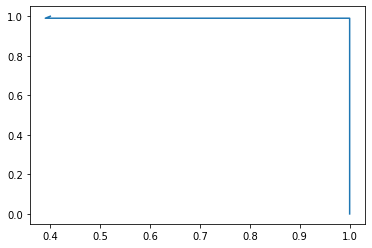

In [167]:
plt.plot(precision, recall)

# Main

## Model 1

In [64]:
def main(saving_folder_name=None, additional_name='', criterion='BCELoss', \
    use_gpu=True, project_name='test', experiment='test', oversampling=False,\
            pred_window=2, observing_window=2, BATCH_SIZE=128, LR=0.0001, min_frequency=1, hidden_size=128,\
                drop=0.6, weight_decay=0, num_epochs=1, wandb_mode='disabled', PRETRAINED_PATH=None, run_id=None):

    # define the device
    if use_gpu:
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    else:
        device='cpu'
    print(f'Device: {device}')         

    CURR_PATH = '/home/svetlanamaslenkova/Documents/AKI_deep/LSTM'
    DF_PATH = CURR_PATH +'/dataframes_2/'
    destination_folder = CURR_PATH + '/training/'
    TXT_FILES_CODES_PATH = '/home/svetlanamaslenkova/Documents/AKI_deep/LSTM/txt_files/icu_train'
    TOKENIZER_CODES_PATH = '/home/svetlanamaslenkova/Documents/AKI_deep/LSTM/aki_prediction/tokenizer_icu_codes.json'
    test_data_path ='/home/svetlanamaslenkova/Documents/AKI_deep/LSTM/dataframes_2/test_data/'
    train_data_path ='/home/svetlanamaslenkova/Documents/AKI_deep/LSTM/dataframes_2/train_data/'
    val_data_path ='/home/svetlanamaslenkova/Documents/AKI_deep/LSTM/dataframes_2/val_data/'

    # Training the tokenizer
    if exists(TOKENIZER_CODES_PATH):
        tokenizer = Tokenizer.from_file(TOKENIZER_CODES_PATH)
        print(f'Tokenizer is loaded from ==> {TOKENIZER_CODES_PATH}/tokenizer.json. Vocab size is {tokenizer.get_vocab_size()}')

    max_lengths_dict = {'demographics':30, 'previous_diags_codes':65, 'labs_codes':240, 'icu_12h_info_codes':120}
    vocab_size = tokenizer.get_vocab_size()
    embedding_size = 200
    dimension = 128

    test_dataset = MyDataset(data_path=test_data_path, tokenizer=tokenizer, max_length_dict=max_lengths_dict)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)

    val_dataset = MyDataset(data_path=val_data_path, tokenizer=tokenizer, max_length_dict=max_lengths_dict)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True)

    train_dataset = MyDataset(data_path=train_data_path, tokenizer=tokenizer, max_length_dict=max_lengths_dict)
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

    if oversampling:
        i = 0
        for _, _, _, _, tensor_labels, _  in train_loader:
            if i == 0:
                stacked_labels = tensor_labels
            else:
                stacked_labels = np.concatenate([stacked_labels, tensor_labels])
            i += 1
        y_train = stacked_labels.T[0]
        count=Counter(y_train)
        class_count=np.array([count[0], count[1]])
        weight=1./class_count
        print('weights for oversampling: ', weight)

        samples_weight = np.array([weight[int(t)] for t in y_train])
        samples_weight=torch.from_numpy(samples_weight)
        sampler = WeightedRandomSampler(samples_weight, len(samples_weight))

        train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, num_workers=1, sampler=sampler)

    model = EHR_MODEL(max_lengths_dict, vocab_size=tokenizer.get_vocab_size()).to(device)
    optimizer = optim.Adam(model.parameters(), lr=LR)

    if PRETRAINED_PATH is not None:
        load_checkpoint(PRETRAINED_PATH, model, optimizer, device)

    exp_lr_scheduler = None

    train_params = {
                'model':model,
                'device':device,
                'optimizer':optimizer,
                'criterion':criterion,
                'train_loader':train_loader,
                'valid_loader':val_loader,
                'num_epochs':num_epochs, 
                'file_path':destination_folder,
                'best_valid_loss':float("Inf"),
                'dimension':128,
                'epoch_patience':15,
                'threshold':None,
                'scheduler':exp_lr_scheduler
            }

    weights = ''
    # path for the model
    if saving_folder_name is None:
        saving_folder_name = additional_name + 'ICU_' + experiment + '_' + str(len(train_dataset) // 1000) + 'k_'  \
            + 'lr' + str(LR) + '_h'+ str(hidden_size) + '_pw' + str(pred_window) + '_ow' + str(observing_window) \
                + '_wd' + str(weight_decay) + '_'+ weights + '_drop' + str(drop)

    
    file_path = destination_folder + saving_folder_name
    train_params['file_path'] = file_path

    if not os.path.exists(file_path):
        os.makedirs(file_path)

    # wandb setup
    os.environ['WANDB_API_KEY'] = '8e859a0fc58f296096842a367ca532717d3b4059'
    run_name = saving_folder_name
    if run_id is None:    
        run_id = wandb.util.generate_id()  
        resume = 'allow' 
    else:
        resume = 'must'

    args = {'optimizer':'Adam', 'criterion':'BCELoss', 'LR':LR, 'min_frequency':min_frequency, 'hidden_size':hidden_size, \
            'pred_window':pred_window, 'experiment':experiment,'weight_decay':weight_decay, 'drop':drop}
    wandb.init(project=project_name, name=run_name, mode=wandb_mode, config=args, id=run_id, resume=resume)
    print('Run id is: ', run_id)
    print('Run name: ', run_name)
    print(f'\n\nMODEL PATH: {file_path}')
    # training
    print('Training started..')
    train(**train_params)

    # testing
    print('\nTesting the model...')
    load_checkpoint(file_path + '/model.pt', model, optimizer, device=device)
    evaluate(model, test_loader, threshold=None, log_res=True)

    wandb.finish()

In [66]:
main(saving_folder_name=None, additional_name='', criterion='BCELoss', \
    use_gpu=True, project_name='test', experiment='test', oversampling=False, 
            pred_window=2, observing_window=2, BATCH_SIZE=128, LR=0.0001, min_frequency=5, hidden_size=128,\
                drop=0.6, weight_decay=0, num_epochs=1, wandb_mode='disabled', PRETRAINED_PATH=None, run_id=None)

Device: cuda
Tokenizer is loaded from ==> /home/svetlanamaslenkova/Documents/AKI_deep/LSTM/aki_prediction/tokenizer_icu_codes.json/tokenizer.json. Vocab size is 8791
Run id is:  7d4me1po
Run name:  ICU_test_11k_lr0.0001_h128_pw2_ow2_wd0__drop0.6


MODEL PATH: /home/svetlanamaslenkova/Documents/AKI_deep/LSTM/training/ICU_test_11k_lr0.0001_h128_pw2_ow2_wd0__drop0.6
Training started..


/home/svetlanamaslenkova/anaconda_envs/aki_env/lib/python3.7/site-packages/ipykernel_launcher.py:112: RuntimeWarning: invalid value encountered in true_divide
/home/svetlanamaslenkova/anaconda_envs/aki_env/lib/python3.7/site-packages/ipykernel_launcher.py:112: RuntimeWarning: invalid value encountered in true_divide


Epoch [1/1], Step [90/90], Train Loss: 0.2002, Valid Loss: 0.1640
Model saved to ==> /home/svetlanamaslenkova/Documents/AKI_deep/LSTM/training/ICU_test_11k_lr0.0001_h128_pw2_ow2_wd0__drop0.6/model.pt
Finished Training!

Testing the model...
Model loaded from <== /home/svetlanamaslenkova/Documents/AKI_deep/LSTM/training/ICU_test_11k_lr0.0001_h128_pw2_ow2_wd0__drop0.6/model.pt
Evaluation..
------------- AKI stage  1 ------------- 
Best Threshold=0.09, F-Score=0.26
Accuracy: 0.88
F1:  0.1
Sensitivity:  0.07
Precision:  0.18
Specificity:  0.97
PR AUC:  0.15
ROC AUC:  0.52
Confusion matrix:
 [[1246   45]
 [ 127   10]]
              precision    recall  f1-score   support

         0.0       0.91      0.97      0.94      1291
         1.0       0.18      0.07      0.10       137

    accuracy                           0.88      1428
   macro avg       0.54      0.52      0.52      1428
weighted avg       0.84      0.88      0.86      1428

Precision 20.0% , Sensitivity 0.21 
Precision 25.0% 

/home/svetlanamaslenkova/anaconda_envs/aki_env/lib/python3.7/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in true_divide
/home/svetlanamaslenkova/anaconda_envs/aki_env/lib/python3.7/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in true_divide
/home/svetlanamaslenkova/anaconda_envs/aki_env/lib/python3.7/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in true_divide
/home/svetlanamaslenkova/anaconda_envs/aki_env/lib/python3.7/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in true_divide


## Model 2

In [151]:
def main(saving_folder_name=None, additional_name='', criterion='BCELoss', \
    use_gpu=True, project_name='test', experiment='test', oversampling=False,\
            pred_window=2, observing_window=2, BATCH_SIZE=128, LR=0.0001, min_frequency=1, hidden_size=128,\
                drop=0.6, weight_decay=0, num_epochs=1, embedding_size=200, dimension = 128, wandb_mode='disabled', PRETRAINED_PATH=None, run_id=None):

    # define the device
    if use_gpu:
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    else:
        device='cpu'
    print(f'Device: {device}')         

    CURR_PATH = '/home/svetlanamaslenkova/Documents/AKI_deep/LSTM'
    DF_PATH = CURR_PATH +'/dataframes_2/'
    destination_folder = CURR_PATH + '/icu_training/'
    TXT_FILES_CODES_PATH = '/home/svetlanamaslenkova/Documents/AKI_deep/LSTM/txt_files/icu_train'
    TOKENIZER_CODES_PATH = '/home/svetlanamaslenkova/Documents/AKI_deep/LSTM/aki_prediction/tokenizer_icu_codes.json'
    test_data_path ='/home/svetlanamaslenkova/Documents/AKI_deep/LSTM/dataframes_2/test_data/'
    train_data_path ='/home/svetlanamaslenkova/Documents/AKI_deep/LSTM/dataframes_2/train_data/'
    val_data_path ='/home/svetlanamaslenkova/Documents/AKI_deep/LSTM/dataframes_2/val_data/'
    # LABELS_PATH = '/home/svetlanamaslenkova/Documents/AKI_deep/LSTM/pickles_2/aki_stage_labels.pkl'

    # with open(LABELS_PATH, 'rb') as f:
    #     aki_stage_labels = pickle.load(f)

    # CURR_PATH = os.getcwd()
    # DF_PATH = CURR_PATH +'icu_data/dataframes_2/'
    # destination_folder = '/l/users/svetlana.maslenkova/models' + '/icu_models/no_pretraining/'
    # TXT_FILES_CODES_PATH = CURR_PATH + '/aki_prediction/txt_files/icu_train'
    # TOKENIZER_CODES_PATH = CURR_PATH + '/aki_prediction/tokenizer_icu_codes.json'
    # test_data_path = CURR_PATH + '/icu_data/dataframes_2/test_data/'
    # train_data_path = CURR_PATH + '/icu_data/dataframes_2/train_data/'
    # val_data_path = CURR_PATH + '/icu_data/dataframes_2/val_data/'
    
    # Training the tokenizer
    print(f'Current directory: {CURR_PATH}')
    if exists(TOKENIZER_CODES_PATH):
        tokenizer = Tokenizer.from_file(TOKENIZER_CODES_PATH)
        print(f'Tokenizer is loaded from ==> {TOKENIZER_CODES_PATH}/tokenizer.json. Vocab size is {tokenizer.get_vocab_size()}')

    vocab_size = tokenizer.get_vocab_size()
    max_length = 350

    train_dataset = MyDataset(data_path=train_data_path, labels_df=None, tokenizer=tokenizer, max_length=max_length)
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

    test_dataset = MyDataset(data_path=test_data_path, labels_df=None, tokenizer=tokenizer, max_length=max_length)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)

    val_dataset = MyDataset(data_path=val_data_path, labels_df=None, tokenizer=tokenizer, max_length=max_length)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True)

    if oversampling:
        i = 0
        for _, _, _, _, tensor_labels, _  in train_loader:
            if i == 0:
                stacked_labels = tensor_labels
            else:
                stacked_labels = np.concatenate([stacked_labels, tensor_labels])
            i += 1
        y_train = stacked_labels.T[0]
        count=Counter(y_train)
        class_count=np.array([count[0], count[1]])
        weight=1./class_count
        print('weights for oversampling: ', weight)

        samples_weight = np.array([weight[int(t)] for t in y_train])
        samples_weight=torch.from_numpy(samples_weight)
        sampler = WeightedRandomSampler(samples_weight, len(samples_weight))

        train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, num_workers=1, sampler=sampler)

    model = EHR_MODEL(max_length=max_length, vocab_size=vocab_size).to(device)
    optimizer = optim.Adam(model.parameters(), lr=LR)

    if PRETRAINED_PATH is not None:
        load_checkpoint(PRETRAINED_PATH, model, optimizer, device)

    exp_lr_scheduler = None

    train_params = {
                'model':model,
                'device':device,
                'optimizer':optimizer,
                'criterion':criterion,
                'train_loader':train_loader,
                'valid_loader':val_loader,
                'num_epochs':num_epochs, 
                'file_path':destination_folder,
                'best_valid_loss':float("Inf"),
                'dimension':128,
                'epoch_patience':15,
                'threshold':None,
                'scheduler':exp_lr_scheduler
            }

    weights = ''
    # path for the model
    if saving_folder_name is None:
        saving_folder_name = additional_name + '_M2_' + 'ICU_' + experiment + '_' + str(len(train_dataset) // 1000) + 'k_'  \
            + 'lr' + str(LR) + '_h'+ str(hidden_size) + '_pw' + str(pred_window) + '_ow' + str(observing_window) \
                + '_wd' + str(weight_decay) + '_'+ weights + '_drop' + str(drop) + '_emb' + str(embedding_size) + '_vocab' + str(vocab_size)
                

    
    file_path = destination_folder + saving_folder_name
    train_params['file_path'] = file_path

    if not os.path.exists(file_path):
        os.makedirs(file_path)

    # wandb setup
    os.environ['WANDB_API_KEY'] = '8e859a0fc58f296096842a367ca532717d3b4059'
    run_name = saving_folder_name
    if run_id is None:    
        run_id = wandb.util.generate_id()  
        resume = 'allow' 
    else:
        resume = 'must'

    args = {'optimizer':'Adam', 'criterion':'BCELoss', 'LR':LR, 'min_frequency':min_frequency, 'hidden_size':hidden_size, \
            'pred_window':pred_window, 'experiment':experiment,'weight_decay':weight_decay, 'drop':drop, 'embedding_size':embedding_size, \
                'vocab_size':vocab_size}

    wandb.init(project=project_name, name=run_name, mode=wandb_mode, config=args, id=run_id, resume=resume)
    print('Run id is: ', run_id)
    print('Run name: ', run_name)
    print(f'\n\nMODEL PATH: {file_path}')
    # training
    print('Training started..')
    train(**train_params)

    # testing
    print('\nTesting the model...')
    load_checkpoint(file_path + '/model.pt', model, optimizer, device=device)
    evaluate(model, test_loader, threshold=None, log_res=True)

    wandb.finish()

In [153]:
main(saving_folder_name='test_model', additional_name='', criterion='BCELoss', \
    use_gpu=True, project_name='test', experiment='test', oversampling=False,\
            pred_window=2, observing_window=2, BATCH_SIZE=512, LR=0.0001, min_frequency=1, hidden_size=128,\
                drop=0.6, weight_decay=0, num_epochs=1, embedding_size=200, dimension = 128, wandb_mode='disabled', \
                    PRETRAINED_PATH=None, run_id=None)

Device: cuda
Current directory: /home/svetlanamaslenkova/Documents/AKI_deep/LSTM
Tokenizer is loaded from ==> /home/svetlanamaslenkova/Documents/AKI_deep/LSTM/aki_prediction/tokenizer_icu_codes.json/tokenizer.json. Vocab size is 8791
Run id is:  1oxyasa4
Run name:  test_model


MODEL PATH: /home/svetlanamaslenkova/Documents/AKI_deep/LSTM/icu_training/test_model
Training started..
Step 0/23
Epoch [1/1], Step [23/23], Train Loss: 3.8169, Valid Loss: 2.0321
Model saved to ==> /home/svetlanamaslenkova/Documents/AKI_deep/LSTM/icu_training/test_model/model.pt
Finished Training!

Testing the model...
Model loaded from <== /home/svetlanamaslenkova/Documents/AKI_deep/LSTM/icu_training/test_model/model.pt
Evaluation..
------------- Stage  ANY ------------- 
Best Threshold=1.00, F-Score=0.18
Accuracy: 0.9
F1:  0.0
Sensitivity:  0.0
Precision:  0.0
Specificity:  1.0
PR AUC:  0.55
ROC AUC:  0.5
Confusion matrix:
 [[1291    0]
 [ 137    0]]
              precision    recall  f1-score   support

    

# LIME

In [75]:
class MyDataset(Dataset):

    def __init__(self, data_path,  tokenizer, labels_df=None, max_length=300, names=True, pred_window=2, observing_window=2):
        # pred_window: number of 12h windows to predict AKI onset
        # observing_window: number of 12h windows to observe
        self.data_path = data_path
        file_list = glob.glob(self.data_path + '*')
        self.data = []
        for sample in file_list:
            self.data.append(sample)

        self.tokenizer = tokenizer
        self.observing_window = observing_window
        self.pred_window = pred_window
        self.max_length = max_length
        self.labels_df = labels_df[labels_df.icu_day_id==1]

        
    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):

        return self.make_matrices(idx)
    
    def tokenize(self, text, max_length):
        
        try:
            output = self.tokenizer.encode(text)
        except:
            print( type(text), text, max_length, self.stay_id)
            output = self.tokenizer.encode(text[0])

        # padding and truncation
        if len(output.ids) < max_length:
            len_missing_token = max_length - len(output.ids)
            padding_vec = [self.tokenizer.token_to_id('PAD') for _ in range(len_missing_token)]
            token_output = [*output.ids, *padding_vec]
        elif len(output.ids) > max_length:
            token_output = output.ids[:max_length]
        else:
            token_output = output.ids
        
        return token_output

    def preproccess(self, df):
        df['demographics'] = df['demographics'].fillna('')
        df['previous_diags_codes'] = df['previous_diags_codes'].fillna('')
        df['previous_diags_names'] = df['previous_diags_names'].fillna('')
        df['vitals_names'] = df['vitals_names'].fillna('')
        df['vitals_codes'] = df['vitals_codes'].fillna('')
        df['labs_names'] = df['labs_names'].fillna('')
        df['labs_codes'] = df['labs_codes'].fillna('')
        df['outputs_names'] = df['outputs_names'].fillna('')
        df['outputs_codes'] = df['outputs_codes'].fillna('')
        df['medications_names'] = df['medications_names'].fillna('')
        df['medications_codes'] = df['medications_codes'].fillna('')
        df = df.replace(r';', '', regex=True)
        df['AKI_1'] = df['AKI_1'].fillna(0)
        df['AKI_2'] = df['AKI_2'].fillna(0)
        df['AKI_3'] = df['AKI_3'].fillna(0)

        df = df[(df.icu_12h_window_id.isin(np.arange(self.min_wind, self.min_wind + self.observing_window +  self.pred_window))) | (df.icu_day_id.isin(np.arange(self.min_day, self.observing_window//2 +  self.pred_window//2)))]
        return df

    def make_matrices(self, idx):
        # load csv file
        sample_path = self.data[idx]
        df = pd.read_csv(sample_path)
        # print('Loaded from ', sample_path)
        
        windows_12h = df.icu_12h_window_id.values
        days = df.icu_day_id.values
        self.min_wind = int( np.max([np.min(windows_12h[~np.isnan(windows_12h)]),0] ) )       
        self.min_day = int( np.max( [np.min(days[~np.isnan(days)]), 0] ))  
        self.df = self.preproccess(df)
        self.stay_id = self.df.stay_id.values[0]  
        # print(stay_id)
        sort = np.argsort(self.df.icu_12h_window_id.values)
        windows_12h = self.df.icu_12h_window_id.values[sort]
        days = self.df.icu_day_id.values[sort]

        info_12h = self.df.icu_12h_info_codes.values[sort]
        info_24h_labs = self.df.labs_codes.values[sort]
        info_demo = self.df.demographics.values[0]
        info_diagnoses = self.df.previous_diags_codes.values[0]

        AKI_1_status = self.df.AKI_1.values[sort]
        AKI_2_status = self.df.AKI_2.values[sort]
        AKI_3_status = self.df.AKI_3.values[sort]

        AKI_1_labels_l = []
        AKI_2_labels_l = []
        AKI_3_labels_l = []
        info_12h_list = []
        info_24h_list = []
        day_l = []
        info_l = []
        used_day_id_l = []
        used_wind_id_l = []

        wind_12h_pairs = [(i, i+1) for i in range(0, 2*(self.min_day + self.observing_window//2 +  self.pred_window//2), 2)]

        for day in range(self.min_day, self.min_day + self.observing_window//2 +  self.pred_window//2):
            for wind in wind_12h_pairs[day]:
                if wind not in windows_12h:
                    if day not in days:
                    # print('not in days')
                        AKI_1_labels_l.append(0)
                        AKI_2_labels_l.append(0)
                        AKI_3_labels_l.append(0)
                        day_l.append('')
                        if day not in used_day_id_l:
                            day_l.append('')
                            used_day_id_l.append(day)
                    else:
                        AKI_1_labels_l.append(self.df[self.df.icu_day_id==day].AKI_1.values[0])
                        AKI_2_labels_l.append(self.df[self.df.icu_day_id==day].AKI_2.values[0])
                        AKI_3_labels_l.append(self.df[self.df.icu_day_id==day].AKI_3.values[0])
                        day_l.append(self.df[self.df.icu_day_id==day].icu_12h_info_codes.values[0])
                        if day not in used_day_id_l:
                            day_l.append(self.df[self.df.icu_day_id==day].labs_codes.values[0])
                            used_day_id_l.append(day)
                else:
                    i = list(windows_12h).index(wind)

                    AKI_1_labels_l.append(AKI_1_status[i])
                    AKI_2_labels_l.append(AKI_2_status[i])
                    AKI_3_labels_l.append(AKI_3_status[i])
                    day_l.append(info_12h[i])
                    if day not in used_day_id_l:
                        day_l.append(info_24h_labs[i])
                        used_day_id_l.append(day)
                used_wind_id_l.append(wind)
            day_info = ' '.join(day_l)
            info_l.append(self.tokenize(day_info, self.max_length))

        demographics = info_demo
        diagnoses = info_diagnoses
        demo_diags = ' '.join([demographics, diagnoses])
        demo_diags = self.tokenize(demo_diags, 50)

        #make tensors
        tensor_day_info = torch.tensor(info_l[:self.observing_window//2], dtype=torch.int64)
        tensor_demo_diags = torch.tensor(demo_diags, dtype=torch.int64)

        if self.labels_df is None:
            # making 24h labels from 12h
            AKI_1_labels = [int(bool(np.sum(AKI_1_labels_l[i:i+2]))) for i in np.arange(0, self.observing_window + self.pred_window, 2)]
            AKI_2_labels = [int(bool(np.sum(AKI_2_labels_l[i:i+2]))) for i in np.arange(0, self.observing_window + self.pred_window, 2)]
            AKI_3_labels = [int(bool(np.sum(AKI_3_labels_l[i:i+2]))) for i in np.arange(0, self.observing_window + self.pred_window, 2)]
            
            tensor_labels = torch.tensor([*AKI_1_labels[self.observing_window//2:self.observing_window//2 + self.pred_window//2],\
                                        *AKI_2_labels[self.observing_window//2:self.observing_window//2 + self.pred_window//2],\
                                        *AKI_3_labels[self.observing_window//2:self.observing_window//2 + self.pred_window//2] ]\
                                            , dtype=torch.float64)
        else:
            AKI_1_label = (np.sum(self.labels_df[self.labels_df.stay_id==self.stay_id].AKI_1.values) > 0).astype(int)
            AKI_2_label = (np.sum(self.labels_df[self.labels_df.stay_id==self.stay_id].AKI_2.values) > 0).astype(int)
            AKI_3_label = (np.sum(self.labels_df[self.labels_df.stay_id==self.stay_id].AKI_3.values) > 0).astype(int)
            NO_AKI_label = (np.sum([AKI_1_label, AKI_2_label, AKI_3_label]) == 0).astype(int)
            tensor_labels = torch.tensor([AKI_1_label, AKI_2_label, AKI_3_label, NO_AKI_label])

        return tensor_day_info, tensor_demo_diags, tensor_labels, {'stay_id':self.stay_id, 'day_id':used_day_id_l, 'wind_id':used_wind_id_l}

In [76]:
frac = 1
BATCH_SIZE = 2
test_data_path ='/home/svetlanamaslenkova/Documents/AKI_deep/LSTM/dataframes_2/test_data/'
train_data_path ='/home/svetlanamaslenkova/Documents/AKI_deep/LSTM/dataframes_2/train_data/'
val_data_path ='/home/svetlanamaslenkova/Documents/AKI_deep/LSTM/dataframes_2/val_data/'

test_dataset = MyDataset(data_path=test_data_path, tokenizer=tokenizer, labels_df=aki_stage_labels, max_length=350)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)

In [46]:
LABELS_PATH = '/home/svetlanamaslenkova/Documents/AKI_deep/LSTM/pickles_2/aki_stage_labels.pkl'

with open(LABELS_PATH, 'rb') as f:
    labels_lstm = pickle.load(f)

In [43]:
labels_lstm

,subject_id,hadm_id,stay_id,specimen_id,day_id,icu_day_id,icu_12h_window_id,charttime,intime,AKI_1_scr,AKI_2_scr,AKI_3_scr,AKI_1_urine,AKI_2_urine,AKI_3_urine,AKI_1,AKI_2,AKI_3,ANY_AKI,NO_AKI
0,16788749,20000808,30610654,63232011.0,5,0,0,2180-01-18 01:54:00,2180-01-17 19:32:10,0,0,0,0.0,0.0,0.0,0,0,0,0,1
1,16788749,20000808,30610654,72894600.0,6,1,2,2180-01-19 03:36:00,2180-01-17 19:32:10,0,0,0,1.0,0.0,0.0,1,0,0,1,0
2,16003661,20001305,36916968,90355490.0,0,0,0,2178-03-25 13:45:00,2178-03-25 02:59:09,0,0,0,1.0,1.0,1.0,0,0,1,1,0
3,16003661,20001305,36916968,92318652.0,1,1,3,2178-03-27 02:12:00,2178-03-25 02:59:09,1,0,0,1.0,1.0,1.0,0,0,1,1,0
4,14577567,20001361,33475095,96321141.0,0,0,0,2143-05-05 04:27:00,2143-05-04 16:52:00,1,0,0,0.0,0.0,0.0,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
223351,10355856,29999625,36975675,93541889.0,17,17,35,2157-11-25 09:48:00,2157-11-07 11:51:00,0,0,0,0.0,0.0,0.0,0,0,0,0,1
223352,10355856,29999625,36975675,43309251.0,18,18,37,2157-11-26 07:05:00,2157-11-07 11:51:00,0,0,0,0.0,0.0,0.0,0,0,0,0,1
223353,10355856,29999625,36975675,73696493.0,19,19,39,2157-11-27 06:15:00,2157-11-07 11:51:00,0,0,0,0.0,0.0,0.0,0,0,0,0,1
223354,10355856,29999625,36975675,77141158.0,20,20,41,2157-11-28 06:38:00,2157-11-07 11:51:00,0,0,0,0.0,0.0,0.0,0,0,0,0,1


In [47]:
activation_fn = nn.Softmax()

In [78]:
model2 = EHR_MODEL(max_length=350, vocab_size=tokenizer.get_vocab_size())

In [80]:
cash

{'stay_id': tensor([35918219, 32151512]),
 'day_id': [tensor([0, 0]), tensor([1, 1])],
 'wind_id': [tensor([0, 0]), tensor([1, 1]), tensor([2, 2]), tensor([3, 3])]}

In [81]:
data_path = '/home/svetlanamaslenkova/Documents/AKI_deep/LSTM/dataframes_2/test_data/icu_stay_31141989.csv'
data_to_test = df = pd.read_csv('/home/svetlanamaslenkova/Documents/AKI_deep/LSTM/dataframes_2/test_data/icu_stay_34711573.csv')
data_to_test = data_to_test[data_to_test.icu_day_id==0]
data_to_test

,subject_id,hadm_id,stay_id,day_id,icu_12h_window_id,icu_day_id,demographics,previous_diags_codes,previous_diags_names,vitals_names,...,labs_codes,outputs_names,outputs_codes,medications_names,medications_codes,AKI_1,AKI_2,AKI_3,icu_12h_info_codes,icu_12h_info_names
1,16230329,23715751,34711573,NaN,0.0,0,WHITE F {54},,,HR {103.0} {123.0} bpm; HR Alarm - High {140....,...,l220228 {13.8}; l220274 {7.53}; l220545 {41.2}...,Foley {600.0} ml; Pre-Admission {1100.0} ml; V...,o226559 {600.0}; o226560 {475.0}; o226633 {110...,Heparin Sodium; Dopamine,m225152 m221662,0.0,0.0,0.0,v220045 {103.0} {123.0}; v220046 {140.0} {14...,HR {103.0} {123.0} bpm; HR Alarm - High {140....
2,16230329,23715751,34711573,0.0,1.0,0,WHITE F {54},,,HR {95.0} {115.0} bpm; HR Alarm - High {130.0...,...,l220228 {13.8}; l220274 {7.53}; l220545 {41.2}...,Void {975.0} ml,o226560 {975.0},Heparin Sodium,m225152,0.0,0.0,0.0,v220045 {95.0} {115.0}; v220046 {130.0} {130...,HR {95.0} {115.0} bpm; HR Alarm - High {130.0...


In [84]:
tensor_day_info, tensor_demo_diags, tensor_labels, cash = MyDataset(data_path, tokenizer=tokenizer, labels_df=aki_stage_labels)[0]
print(tensor_day_info.size())
print(tensor_demo_diags.size())

torch.Size([1, 300])
torch.Size([50])


In [85]:
def predict_proba(model, data_path):
    input_ = MyDataset(data_path, tokenizer=tokenizer, labels_df=aki_stage_labels)[0]
    tensor_day_info, tensor_demo_diags, tensor_labels, cash = input_
    output = model(tensor_day_info, tensor_demo_diags)
    proba = activation_fn(output)
    return proba

In [90]:
predict_proba(model2, data_path)

out_emb_demo_diags:  torch.Size([50, 200])
out_emb_day_info:  torch.Size([300, 200])


IndexError: Dimension out of range (expected to be in range of [-2, 1], but got 2)

In [ ]:
from lime.lime_text import LimeTextExplainer

class_names=['no_aki','aki_1', 'aki_2', 'aki_3']
explainer= LimeTextExplainer(class_names=class_names)

